In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree, lax, value_and_grad
jconfig.update("jax_enable_x64", True)
print(jdevices())

# from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload , Path
# from pathlib import Path

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname
#!jupyter nbconvert --to python /dvs_ro/u1/h/hsimfroy/workspace/montecosmo_proj/src/montecosmo/tests/infer_model2.ipynb

# save_dir = Path("./save/")
# save_dir = Path(os.path.expanduser("~/scratch/png/abacus_c0_i0_z08_lrg/test")) # FMN
# load_dir = Path(os.path.expanduser("~/scratch/png/abacus_c0_i0_z08_lrg/load/")) # FMN
# save_dir = Path("/lustre/fsn1/projects/rech/fvg/uvs19wt/png/") # JZ
# save_dir = Path("/lustre/fswork/projects/rech/fvg/uvs19wt/workspace/png/") # JZ
save_dir = Path("/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z08_lrg/noise") # Perlmutter
load_dir = Path("/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z08_lrg/load/") # Perlmutter
# save_path = save_dir / "test"
save_dir.mkdir(parents=True, exist_ok=True)

ERROR:2025-11-21 15:10:11,700:jax._src.xla_bridge:473: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/global/u1/h/hsimfroy/miniforge3/envs/montenv/lib/python3.14/site-packages/jax_plugins/xla_cuda12/__init__.py", line 201, in _version_check
    version = get_version()
RuntimeError: jaxlib/cuda/versions_helpers.cc:81: operation cusparseGetProperty(MAJOR_VERSION, &major) failed: The cuSPARSE library was not found.

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/global/u1/h/hsimfroy/miniforge3/envs/montenv/lib/python3.14/site-packages/jax/_src/xla_bridge.py", line 471, in discover_pjrt_plugins
    plugin_module.initialize()
    ~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/global/u1/h/hsimfroy/miniforge3/envs/montenv/lib/python3.14/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_e

[CpuDevice(id=0)]


ModuleNotFoundError: No module named 'montecosmo'

## Import

In [2]:
import glob
cosmo, ic, z_obs, tracer = 0, 0, 0.8, 'LRG'
mesh_length, resampler = 576, 'ngp'

fn = {}
outdir = Path(os.getenv('SCRATCH')) / f'bias/{tracer}/z{z_obs:.3f}/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/'
fn['catalog_tracer'] = f'/dvs_ro/cfs/cdirs/desi/cosmosim/SecondGenMocks/CubicBox/{tracer}/z{z_obs:.3f}/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/LRG_real_space.fits'
fn['mesh_ic'] = f'/dvs_ro/cfs/cdirs/desi/public/cosmosim/AbacusSummit/ic/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/ic_dens_N576.asdf'
fns = [glob.glob(f'/dvs_ro/cfs/cdirs/desi/public/cosmosim/AbacusSummit/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/halos/z{z_obs:.3f}/{t}_rv_A/{t}_rv_A_*.asdf') for t in ['field', 'halo']]
fn['catalog_particle'] = sorted(sum(fns, []))
fns = fn

In [ ]:
# IC
def read_mesh(fn, z=None):
    fn = str(fn)
    import asdf
    with asdf.open(fn) as af:
        growth_table = 1.
        if z is not None:
            growth_table = af['header']['GrowthTable'][z]
        toret = jnp.array(af['data']['density']) * growth_table
    return toret
init_mesh = read_mesh(fns['mesh_ic'], z=0)
shape = init_mesh.shape
print(shape)
jnp.save(load_dir / f'init_mesh_{mesh_length}.npy', init_mesh)

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250331-1.0.0/conda/lib/python3.10/site-packages/asdf/yamlutil.py:355: AsdfConversionWarning: tag:stsci.edu:asdf/core/column-1.0.0 is not recognized, converting to raw Python data structure
  warnings.warn(
/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250331-1.0.0/conda/lib/python3.10/site-packages/asdf/yamlutil.py:355: AsdfConversionWarning: tag:astropy.org:astropy/table/table-1.0.0 is not recognized, converting to raw Python data structure
  warnings.warn(
/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250331-1.0.0/conda/lib/python3.10/site-packages/asdf/_asdf.py:294: AsdfPackageVersionWarning: File 'file:///dvs_ro/cfs/cdirs/desi/public/cosmosim/AbacusSummit/ic/AbacusSummit_base_c000_ph000/ic_dens_N576.asdf' was created with extension URI 'asdf://astropy.org/astropy/extensions/astropy-1.0.0' (from package asdf-astropy==0.2.2), which is not currently installed
  w

(576, 576, 576)


In [3]:
from itertools import product

def rfftk(shape):
    kx = np.fft.fftfreq(shape[0]) * 2 * np.pi
    ky = np.fft.fftfreq(shape[1]) * 2 * np.pi
    kz = np.fft.rfftfreq(shape[2]) * 2 * np.pi

    kx = kx.reshape([-1, 1, 1])
    ky = ky.reshape([1, -1, 1])
    kz = kz.reshape([1, 1, -1])
    return kx, ky, kz

def r2chshape(shape):
    return (*shape[:2], shape[2]//2+1)

def ch2rshape(shape):
    return (*shape[:2], 2*(shape[2]-1))

def rectangular(s, order):
    funclist = [
        lambda s: jnp.full(jnp.shape(s)[-1:], jnp.inf), # Dirac
        lambda s: jnp.full(jnp.shape(s)[-1:], 1.), # NGP
        lambda s: 1 - s, # CIC
        lambda s: (s <= 1/2) * (3/4 - s**2) + (1/2 < s) / 2 * (3/2 - s)**2, # TSC
        lambda s: (s <= 1) / 6 * (4 - 6 * s**2 + 3 * s**3) + (1 < s) / 6 * (2 - s)**3, # PCS
    ]
    return funclist[order](jnp.abs(s))

def rectangular_hat(kvec, order:int=2):
    kernel = lambda k: np.sinc(k / (2 * np.pi))**order
    out = 1.
    for ki in kvec:
        out = out * kernel(ki)
    return out

def kaiser_bessel(s, order, kcut):
    """
    See [Barnet+2019](http://arxiv.org/abs/1808.06736)
    """
    s = s * 2 / order
    kcut = kcut * order / 2
    out = jnp.i0(kcut * (1 - s**2)**.5)
    out /= order * jnp.sinh(kcut) / kcut
    return out

def kaiser_bessel_hat(kvec, order, kcut):
    """
    See [Barnet+2019](http://arxiv.org/abs/1808.06736)
    """
    def kernel(k, kcut):
        k = k * order / 2
        kcut = kcut * order / 2
        dist = jnp.abs(kcut**2 - k**2)**.5
        bulk = jnp.sinh(dist) / dist
        tail = jnp.sin(dist) / dist
        out = jnp.where(jnp.abs(k) <= kcut, bulk, tail)
        out /= jnp.sinh(kcut) / kcut
        return out

    out = 1.
    for ki in kvec:
        out = out * kernel(ki, kcut)
    return out

def deconv_paint(mesh, order:int=2, kernel_type='rectangular', oversamp=1.):
    """
    Deconvolve the mesh by the paint kernel of given order and type.
    """
    if kernel_type == 'rectangular':
        kernel = lambda kvec: rectangular_hat(kvec, order)
    elif kernel_type == 'kaiser_bessel':
        kernel = lambda kvec: kaiser_bessel_hat(kvec, order, optim_kcut(oversamp))
    
    if jnp.isrealobj(mesh):
        kvec = rfftk(mesh.shape)
        mesh = jnp.fft.rfftn(mesh)
        mesh /= kernel(kvec)
        mesh = jnp.fft.irfftn(mesh)
    else:
        kvec = rfftk(ch2rshape(mesh.shape))
        mesh /= kernel(kvec)
    return mesh

def optim_kcut(oversamp, safety=0.98):
    """
    See [Barnet+2019](http://arxiv.org/abs/1808.06736)
    """
    return safety * jnp.pi * (2 - 1 / oversamp)

def paint(pos, shape:tuple, weights=1., order:int=2, kernel_type='rectangular', oversamp=1.):
    """
    Paint the positions onto the mesh. 
    If mesh is a tuple, paint on a zero mesh with such shape.
    """
    dtype = 'int16' # int16 -> +/- 32_767, trkl
    shape = np.asarray(shape, dtype=dtype)
    mesh = jnp.zeros(shape)
    def wrap(idx):
        return idx % shape
    
    id0 = (jnp.round if order % 2 else jnp.floor)(pos).astype(dtype)
    ishifts = np.arange(order) - (order - 1) // 2
    ishifts = np.array(list(product(* len(shape) * (ishifts,))), dtype=dtype)

    if kernel_type == 'rectangular':
        kernel = lambda s: rectangular(s, order)
    elif kernel_type == 'kaiser_bessel':
        kernel = lambda s: kaiser_bessel(s, order, optim_kcut(oversamp))

    def step(carry, ishift):
        idx = id0 + ishift
        idx, ker = wrap(idx), kernel(idx - pos).prod(-1)

        # idx = jnp.unstack(idx, axis=-1)
        idx = tuple(jnp.moveaxis(idx, -1, 0)) # TODO: JAX >= 0.4.28 for unstack
        carry = carry.at[idx].add(weights * ker)
        return carry, None

    mesh = lax.scan(step, mesh, ishifts)[0]
    return mesh

def read(pos, mesh:jnp.ndarray, order:int=2, kernel_type='rectangular', oversamp=1.):
    """
    Read the value at the positions from the mesh.
    """
    dtype = 'int16' # int16 -> +/- 32_767, trkl
    shape = np.asarray(mesh.shape, dtype=dtype)
    def wrap(idx):
        return idx % shape
    
    id0 = (jnp.round if order % 2 else jnp.floor)(pos).astype(dtype)
    ishifts = np.arange(order) - (order - 1) // 2
    ishifts = np.array(list(product(* len(shape) * (ishifts,))), dtype=dtype)

    if kernel_type == 'rectangular':
        kernel = lambda s: rectangular(s, order)
    elif kernel_type == 'kaiser_bessel':
        kernel = lambda s: kaiser_bessel(s, order, optim_kcut(oversamp))
    
    def step(carry, ishift):
        idx = id0 + ishift
        idx, ker = wrap(idx), kernel(idx - pos).prod(-1)

        # idx = jnp.unstack(idx, axis=-1)
        idx = tuple(jnp.moveaxis(idx, -1, 0)) # TODO: JAX >= 0.4.28 for unstack
        carry += mesh[idx] * ker
        return carry, None
    
    out = jnp.zeros(id0.shape[:-1])
    out = lax.scan(step, out, ishifts)[0]
    return out

def interlace(pos, shape:tuple, weights=1., paint_order:int=2, interlace_order:int=2, 
              kernel_type='rectangular', oversamp=1., deconv=True):
    """
    Equal-spacing interlacing. Carefull with `interlace_order`>=3, it is not isotropic.
    See [Wang&Yu2024](https://arxiv.org/abs/2403.13561)
    """
    kvec = rfftk(shape)
    mesh = jnp.zeros(r2chshape(shape), dtype=complex)
    shifts = jnp.arange(interlace_order) / interlace_order

    def step(carry, shift):
        mesh = paint(pos + shift, shape, weights, paint_order, kernel_type, oversamp)
        carry += jnp.fft.rfftn(mesh) * jnp.exp(1j * shift * sum(kvec)) / interlace_order
        return carry, None

    mesh = lax.scan(step, mesh, shifts)[0]
    if deconv:
        mesh = deconv_paint(mesh, paint_order, kernel_type=kernel_type, oversamp=oversamp)
    return mesh

def chreshape(mesh, shape):
    """
    Reshape a complex Hermitian tensor (3D),
    handling correctly zero-padding.
    """
    ids_shape = tuple(np.minimum(mesh.shape, shape))
    scale = np.divide(ch2rshape(shape), ch2rshape(mesh.shape)).prod()
    ids = tuple(np.roll(np.arange(-(s//2), (s+1)//2), -(s//2)) for s in ids_shape[:-1])
    ids += (np.arange(ids_shape[-1]),)
    
    if ids_shape == shape: # downsample all axis
        out = mesh[np.ix_(*ids)]
    elif ids_shape == mesh.shape: # oversample all axis
        out = jnp.zeros(shape, dtype=complex)
        out = out.at[np.ix_(*ids)].set(mesh)
    else: # down or oversample
        out = jnp.zeros(shape, dtype=complex)
        ids = np.ix_(*ids)
        out = out.at[ids].set(mesh[ids])
    return out * scale

In [5]:
# Particle
from abacusnbody.data import read_abacus
from tqdm import tqdm
paint_order = 2
# mesh_lengths = [32, 64, 128, 256]
# mesh_lengths = [32, 64, 128, 256, 576]
mesh_lengths = [576, 96]
# jpaint = jit(partial(paint, order=paint_order))
jinterlace = (partial(interlace, paint_order=paint_order, interlace_order=1, deconv=False, kernel_type="kaiser_bessel", oversamp=1.))

for mesh_length in mesh_lengths:
    shape = 3*(mesh_length,)
    pos_min, pos_max = -1000., 1000.
    init_paint = jnp.zeros(shape)
    # fin_paint = jnp.zeros(shape)
    fin_paint = jnp.zeros(r2chshape(shape))

    for fn in tqdm(fns['catalog_particle']):
        # init_pos = read_abacus.read_asdf(fn.replace('_rv', '_pid'), load=['lagr_pos'])['lagr_pos']
        # init_pos = (init_pos - pos_min) / (pos_max - pos_min) * mesh_length
        # # init_paint = jpaint(init_pos, init_paint)
        # init_paint += jnp.fft.irfftn(jinterlace(init_pos, shape))

        fin_pos = read_abacus.read_asdf(fn, load=['pos'])['pos']
        fin_pos = (fin_pos - pos_min) / (pos_max - pos_min) * mesh_length
        # fin_paint = jpaint(fin_pos, mesh_shape)
        # fin_paint += jnp.fft.irfftn(jinterlace(fin_pos, shape))
        fin_paint += jinterlace(fin_pos, shape)

    # 51.840 part/cell for 576^3, thus ~9.91e+09 parts total"
    # init_paint /= init_paint.mean()
    # jnp.save(load_dir / f"init_paint2_interl2_deconv0_{mesh_length}.npy", init_paint)

    fin_paint2 = jnp.fft.irfftn(fin_paint)
    fin_paint2 /= fin_paint2.mean()
    jnp.save(load_dir / f"fin_kbpaint2_interl1_deconv0_at{mesh_length}.npy", fin_paint2)

    fin_paint2 = deconv_paint(fin_paint, paint_order, kernel_type='rectangular', oversamp=2.)
    fin_paint2 = jnp.fft.irfftn(fin_paint2)
    fin_paint2 /= fin_paint2.mean()
    jnp.save(load_dir / f"fin_kbpaint2_interl1_deconv1_at{mesh_length}.npy", fin_paint2)

  0%|                                                             | 0/68 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████| 68/68 [06:56<00:00,  6.12s/it]


In [4]:
# Tracer
import fitsio
# paint_order = 4
paint_length = 576
fin_length = 96
deconv = True
# deconv = False

def get_tracer_mesh(paint_length, fin_length,
                    paint_order, interlace_order, kernel_type='rectangular', oversamp=2., deconv=True):
    jinterlace = (partial(interlace, paint_order=paint_order, interlace_order=interlace_order, 
                          kernel_type=kernel_type, oversamp=oversamp, deconv=deconv))
    positions = fitsio.read(fns['catalog_tracer'])
    positions = np.column_stack([positions[name] for name in ['x', 'y', 'z']])
    print(len(positions), positions.min(0), positions.max(0))
    positions = (positions - positions.min()) / (positions.max() - positions.min()) * paint_length
    print("pos min:", positions.min(), "max:", positions.max())

    tracer_mesh = jinterlace(positions, 3*(paint_length,))
    tracer_mesh *= np.prod(3*(paint_length,)) / len(positions)

    tracer_mesh = jnp.fft.irfftn(chreshape(tracer_mesh, r2chshape(3*(fin_length,))))
    # tracer_mesh = jnp.fft.irfftn(tracer_mesh)
    return tracer_mesh

paint_order, deconv = 2, True
tracer_mesh = get_tracer_mesh(paint_length, fin_length, paint_order=paint_order, interlace_order=1, deconv=deconv)-1
tracer_mesh2 = get_tracer_mesh(fin_length, fin_length, paint_order=paint_order, interlace_order=1, deconv=deconv)-1
tracer_mesh3 = get_tracer_mesh(paint_length, fin_length, paint_order=paint_order, interlace_order=2, deconv=deconv)-1
tracer_mesh4 = get_tracer_mesh(fin_length, fin_length, paint_order=paint_order, interlace_order=2, deconv=deconv)-1
print("mesh mean:", tracer_mesh.mean(), "shape:", tracer_mesh.shape)
# np.save(load_dir / f'tracer_{len(positions)}_paint{paint_order}_deconv{deconv:d}_{mesh_length}.npy', tracer_mesh)

6746545 [-1000.          -999.99938965 -1000.        ] [ 999.99957275  999.99975586 1000.        ]
pos min: 0.0 max: 576.0
6746545 [-1000.          -999.99938965 -1000.        ] [ 999.99957275  999.99975586 1000.        ]
pos min: 0.0 max: 96.0
6746545 [-1000.          -999.99938965 -1000.        ] [ 999.99957275  999.99975586 1000.        ]
pos min: 0.0 max: 576.0
6746545 [-1000.          -999.99938965 -1000.        ] [ 999.99957275  999.99975586 1000.        ]
pos min: 0.0 max: 96.0
mesh mean: -5.637851296924623e-17 shape: (96, 96, 96)


mean: -5.29733e-17, std: 1.18293e+00, mesh p.05-.95: [-1.35933718  2.27480427]
mean: -5.63785e-17, std: 1.05910e+00, mesh p.05-.95: [-1.39253803  1.97300979]
mean: -9.57310e-18, std: 1.07122e+00, mesh p.05-.95: [-1.40097965  1.99704292]
mean: -5.52542e-17, std: 1.05910e+00, mesh p.05-.95: [-1.39254815  1.97258969]


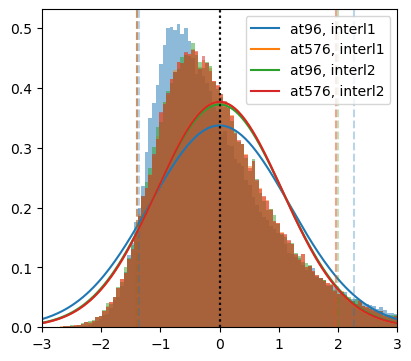

In [12]:
def plot_pdf(mesh, label, vlim=1e-2):
    # mesh = jnp.log10(1+mesh[mesh>1e-2])
    print(f"mean: {mesh.mean():.5e}, std: {mesh.std():.5e}, mesh p.05-.95: {np.quantile(mesh, [0.05, 0.95])}")
    if vlim is None:
        vlim = mesh.min(), mesh.max()
    elif isinstance(vlim, float):
        vlim = np.quantile(mesh, [vlim/2, 1-vlim/2])

    from scipy.stats import norm
    x = np.linspace(*vlim, 200)
    pdf = norm.pdf(x, loc=mesh.mean(), scale=mesh.std())
    color = plt.gca()._get_lines.get_next_color()
    plt.plot(x, pdf, label=label, color=color)
    plt.hist(jr.choice(jr.key(48), mesh.ravel(), (100000,), replace=False), range=vlim, bins=100, density=True, color=color, alpha=0.5)
    plt.axvline(0., color='k', linestyle=':', alpha=0.5)

    q05, q95 = np.quantile(np.asarray(mesh), [0.05, 0.95])
    plt.axvline(q05, color=color, linestyle='--', alpha=0.3)
    plt.axvline(q95, color=color, linestyle='--', alpha=0.3)
    plt.xlim(vlim)
    plt.legend();

plt.figure(figsize=(4, 3.5), layout="constrained")
# vlim = -10, 10.
vlim = -3, 3.
plot_pdf(tracer_mesh2, "at96, interl1", vlim)
plot_pdf(tracer_mesh, "at576, interl1", vlim)
plot_pdf(tracer_mesh4, "at96, interl2", vlim)
plot_pdf(tracer_mesh3, "at576, interl2", vlim)
# plt.savefig(f"./figs/abacus_matter_pdf_paint{paint_order:d}_deconv{deconv:d}.png")  

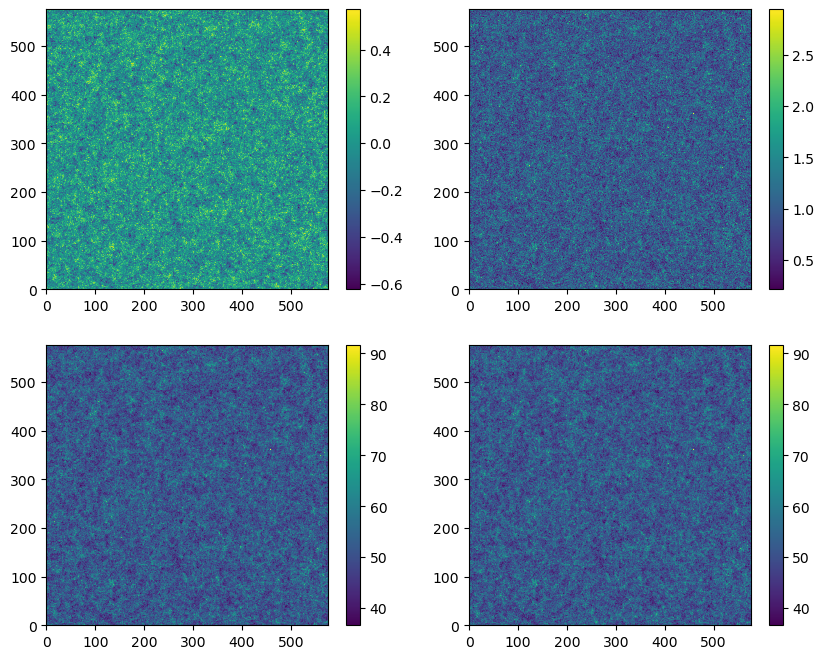

In [8]:
init_mesh0 = jnp.load(save_dir / f"init_mesh_{mesh_length}.npy")
tracer_mesh0 = jnp.load(save_dir / f"tracer_mesh_6746545_{mesh_length}.npy")
init_paint = jnp.load(save_dir / f"init_paint_{mesh_length}.npy")
fin_paint = jnp.load(save_dir / f"fin_paint_{mesh_length}.npy")
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.pcolormesh(init_mesh0.mean(2))
plt.colorbar()
plt.subplot(222)
plt.pcolormesh(tracer_mesh0.mean(2))
plt.colorbar()
plt.subplot(223)
plt.pcolormesh(fin_paint.mean(2))
plt.colorbar()
plt.subplot(224)
plt.pcolormesh(fin_paint.mean(2))
plt.colorbar()
plt.show()

In [ ]:
import plotly.express as px
idx = np.random.choice(positions.shape[0], size=10000, replace=False)
pos = positions[idx]

fig = px.scatter_3d(
    x=pos[:, 0],
    y=pos[:, 1],
    z=pos[:, 2],
    title="Random Sample of 10,000 Positions"
)
fig.update_traces(marker=dict(size=2))
fig.show()

In [19]:
from cosmoprimo.fiducial import AbacusSummit
cosmo = AbacusSummit(0)
pk_interpolator = cosmo.get_fourier().pk_interpolator().to_1d(z=0.)

n_interp = 256
ks = jnp.logspace(-4, 1, n_interp)
pows = pk_interpolator(ks) / cosmo.get_fourier().sigma8_m**2
init_kpow = jnp.stack((ks, pows))

np.save(load_dir / f'init_kpow.npy', init_kpow)
print("Omega_m:", cosmo['Omega_m'], "sigma8:", cosmo.get_fourier().sigma8_m)
cosmo.get_params('cosmology')

Omega_m: 0.3151917236644108 sigma8: 0.8076353990239834


{'h': array(0.6736),
 'Omega_cdm': array(0.26447041),
 'Omega_b': array(0.04930169),
 'Omega_k': 0.0,
 'sigma8': 0.8,
 'k_pivot': 0.05,
 'n_s': 0.9649,
 'alpha_s': 0.0,
 'beta_s': 0.0,
 'r': 0.0,
 'n_t': -0.0,
 'alpha_t': -0.0,
 'T_cmb': array(2.7255),
 'm_ncdm': array([0.05999992]),
 'neutrino_hierarchy': None,
 'T_ncdm_over_cmb': array([0.71611]),
 'N_eff': 3.044,
 'tau_reio': 0.0544,
 'reionization_width': 0.5,
 'A_L': 1.0,
 'w0_fld': array(-1.),
 'wa_fld': array(0.),
 'cs2_fld': array(1.),
 'H0': 0.7,
 'omega_cdm': 0.25,
 'Omega_c': 0.25,
 'omega_c': 0.25,
 'Omega_m': 0.25,
 'omega_m': 0.25,
 'Omega0_cdm': 0.25,
 'omch2': 0.25,
 'Omega0_m': 0.25,
 'omega_b': 0.05,
 'Omega0_b': 0.05,
 'ombh2': 0.05,
 'omega_k': 0.0,
 'Omega0_k': 0.0,
 'A_s': array(2.083e-09),
 'logA': 0.8,
 'ln10^10A_s': 0.8,
 'ln10^{10}A_s': 0.8,
 'ln_A_s_1e10': 0.8,
 'ns': 0.96,
 'nrun': 0.0,
 'nrunrun': 0.0,
 'Omega_g': 2.7255,
 'omega_g': 2.7255,
 'T0_cmb': 2.7255,
 'Omega0_g': 2.7255,
 'Omega_ncdm': None,
 'ome

## Validation

### Abacus meshes

In [ ]:
from montecosmo.utils import chreshape, r2chshape
def fourier_subsample(mesh0, mesh_length):
    mesh = jnp.fft.rfftn(mesh0)
    mesh = chreshape(mesh, r2chshape(3*(mesh_length,)))
    mesh = jnp.fft.irfftn(mesh)
    return mesh

# mesh0 = jnp.load(load_dir / f"tracer_6746545_paint2_deconv1_{576}.npy")
# mesh0 = deconv_paint(mesh0, order=2)
mesh_lengths = [256,128,96,64,32]
for m in mesh_lengths:
    tmesh = fourier_subsample(mesh0, m)
    save_path = load_dir / (f"tracer_6746545_paint2_deconv1_{m}.npy")
    jnp.save(save_path, tmesh)

mean_576: 1.000
mean_256: 1.000
mean_128: 1.000
mean_64: 1.000
mean_32: 1.000


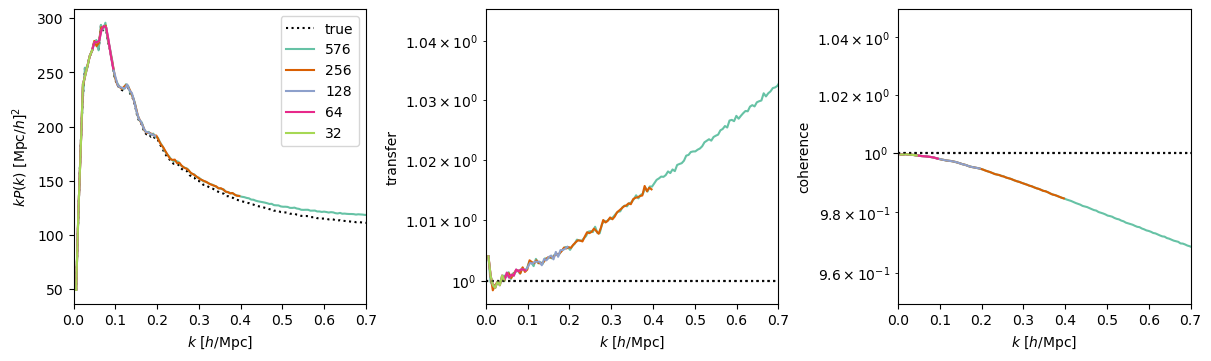

In [ ]:
from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
from montecosmo.metrics import powtranscoh
from montecosmo.metrics import spectrum
from montecosmo.utils import chreshape, r2chshape
from matplotlib import colors
theme(usetex=False)
log = False
cmap = None
mesh_lengths = [576, 256, 128, 64, 32]
xlim = (0, .7)
box_size = np.array(3*(2000,))

def fourier_subsample(mesh0, mesh_length):
    mesh = jnp.fft.rfftn(mesh0)
    mesh = chreshape(mesh, r2chshape(3*(mesh_length,)))
    mesh = jnp.fft.irfftn(mesh)
    return mesh

plt.figure(figsize=(12, 3.5), layout="constrained")

for mesh_length in mesh_lengths:
    mesh0 = jnp.load(load_dir / f"fin_paint2_interl2_deconv1_{mesh_length}.npy")
    # mesh1 = jnp.load(load_dir / f"fin_paint_deconv_{mesh_length}.npy")
    noise = jr.normal(jr.key(45), 3*(576,))
    noise = fourier_subsample(noise, mesh_length)
    mesh1 = mesh0 + 0.5 * noise
    

    # TODO: add noise, that is fourier truncated
    print(f'mean_{mesh_length}: {mesh0.mean():.3f}')

    plt.subplot(131)
    plt.xlim(xlim)
    if mesh_length == mesh_lengths[0]:
        plot_pow(*spectrum(mesh0, box_size=box_size), 'k:', log=log, label="true")
    kptc1 = powtranscoh(mesh0, mesh1, box_size=box_size)
    plot_powtranscoh(*kptc1, log=log, label=mesh_length)
    plt.subplot(131)
    plt.legend()
    plt.subplot(132)
    plt.xlim(xlim)
    plt.axhline(1., linestyle=':', color='k', alpha=0.5)
    plt.subplot(133)
    plt.xlim(xlim)
    plt.ylim(.95,1.05)
    plt.axhline(1., linestyle=':', color='k', alpha=0.5);
# plt.savefig(f"./figs/abacus_matter_pow_interl2_deconv1_noise01.png")

mean_576: 1.000
mean_256: 1.000
mean_128: 1.000
mean_64: 1.000
mean_32: 1.000


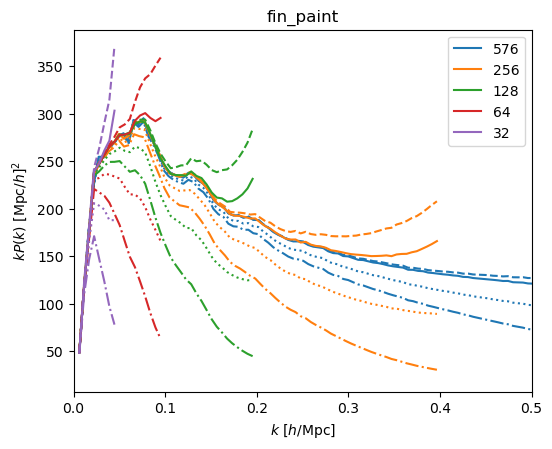

In [ ]:
from montecosmo.plot import plot_mesh, plot_pow, theme
from montecosmo.utils import chreshape, r2chshape
from montecosmo.metrics import spectrum
from montecosmo.bricks import AbacusSummit0
from montecosmo.nbody import deconv_paint
theme(cmap=None)

def fourier_subsample(mesh0, mesh_length):
    mesh = jnp.fft.rfftn(mesh0)
    mesh = chreshape(mesh, r2chshape(3*(mesh_length,)))
    mesh = jnp.fft.irfftn(mesh)
    return mesh

names = ["fin_paint"]
mesh_lengths = [576, 256, 128, 64, 32]
box_size = np.array(3*(2000,))
n_tracers = 6746545
cosmo = AbacusSummit0()
log = False

plt.figure(figsize=(10, 8), layout='constrained')
for i_plot, name in enumerate(names):
    plt.subplot(2,2,i_plot+1)
    plt.title(name)
    plt.xlim(0,0.5)

    if name == "init_mesh":
        init_kpow = jnp.load(load_dir / 'init_kpow.npy')
        init_kpow = (init_kpow[0], init_kpow[1] * cosmo.sigma8**2)
        plot_pow(*init_kpow, 'k+-', log=log, label="theory")

    for m in mesh_lengths:
        color = plt.gca()._get_lines.get_next_color()

        if name == "fin_paint":
            save_path = load_dir / (name + f"2_at_{m}.npy")
            tmesh = jnp.load(save_path)
            tmesh = deconv_paint(tmesh, order=2)
            kpow = spectrum(tmesh, box_size=box_size)
            plot_pow(*kpow, "-", log=log, color=color, label=f"{m}")
            print(f'mean_{m}: {tmesh.mean():.3f}')

            save_path = load_dir / (name + f"1_at_{m}.npy")
            tmesh = jnp.load(save_path)
            tmesh = deconv_paint(tmesh, order=1)
            kpow = spectrum(tmesh, box_size=box_size)
            plot_pow(*kpow, "--", log=log, color=color)

            save_path = load_dir / (name + f"2_at_{m}.npy")
            tmesh = jnp.load(save_path)
            # mesh = deconv_paint(mesh, order=2)
            kpow = spectrum(tmesh, box_size=box_size)
            plot_pow(*kpow, "-.", log=log, color=color)

            save_path = load_dir / (name + f"1_at_{m}.npy")
            tmesh = jnp.load(save_path)
            # mesh = deconv_paint(mesh, order=1)
            kpow = spectrum(tmesh, box_size=box_size)
            plot_pow(*kpow, ":", log=log, color=color)

    plt.legend()
# plt.savefig(f"./figs/abacus_matter_pow_paint12_deconv01.png")      
# plt.show()

mean_576: -0.000
mean_256: -0.000
mean_128: -0.000
mean_64: -0.000
mean_32: -0.000

mean_576: 1.000
mean_256: 1.000
mean_128: 1.000
mean_64: 1.000
mean_32: 1.000

mean_576: 1.000
mean_256: 1.000
mean_128: 1.000
mean_64: 1.000
mean_32: 1.000

mean_576: 1.000
mean_256: 1.000
mean_128: 1.000
mean_64: 1.000
mean_32: 1.000



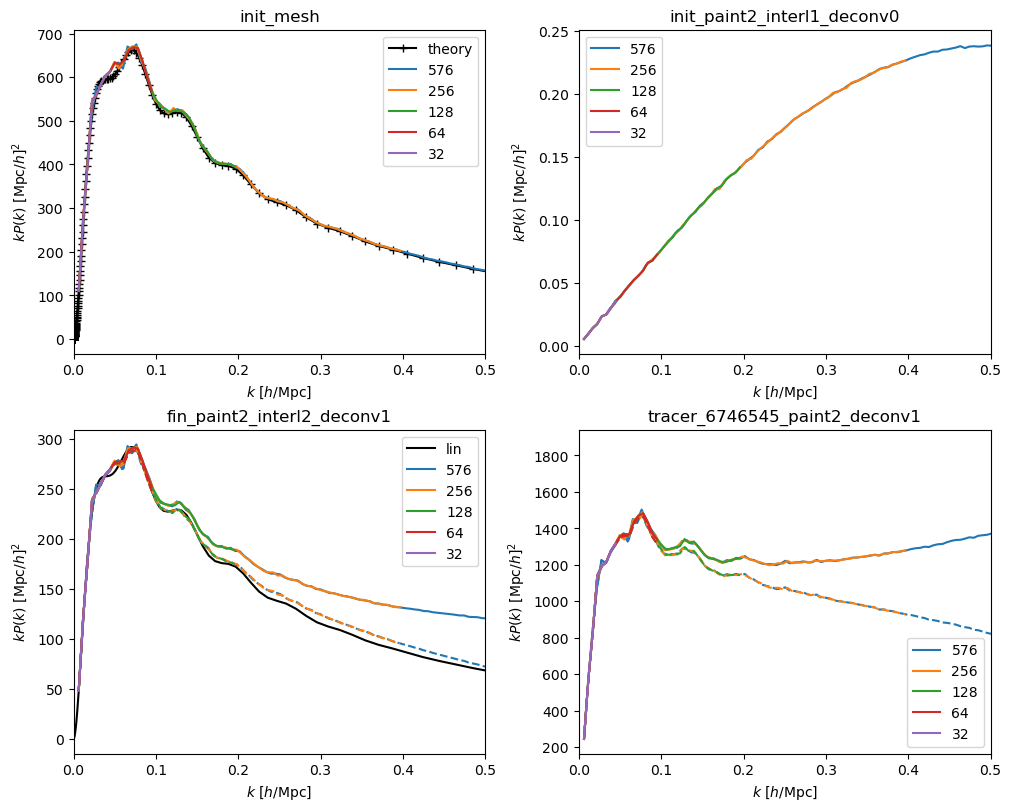

In [ ]:
from montecosmo.plot import plot_mesh, plot_pow, theme
from montecosmo.utils import chreshape, r2chshape
from montecosmo.metrics import spectrum
from montecosmo.bricks import AbacusSummit0
from montecosmo.nbody import deconv_paint, a2g
theme(cmap=None)

def fourier_subsample(mesh0, mesh_length):
    mesh = jnp.fft.rfftn(mesh0)
    mesh = chreshape(mesh, r2chshape(3*(mesh_length,)))
    mesh = jnp.fft.irfftn(mesh)
    return mesh

names = ["init_mesh", "init_paint2_interl1_deconv0", "fin_paint2_interl2_deconv1", "tracer_6746545_paint2_deconv1"]
mesh_lengths = [576,256,128,64,32]
box_size = np.array(3*(2000,))
n_tracers = 6746545
cosmo = AbacusSummit0()
log = False
z_obs = 0.8

plt.figure(figsize=(10, 8), layout='constrained')
for i_plot, name in enumerate(names):
    plt.subplot(2,2,i_plot+1)
    plt.title(name)
    plt.xlim(0,0.5)

    # plot_mesh(mesh0)
    # plt.colorbar()

    if name == "init_mesh":
        init_kpow = jnp.load(load_dir / 'init_kpow.npy')
        init_kpow = (init_kpow[0], init_kpow[1] * cosmo.sigma8**2)
        plot_pow(*init_kpow, 'k+-', log=log, label="theory")

    if name == "fin_paint2_interl2_deconv1":
        init_kpow = jnp.load(load_dir / 'init_kpow.npy')
        init_kpow = (init_kpow[0], init_kpow[1] * cosmo.sigma8**2 * a2g(cosmo, 1/(1+z_obs))**2)
        plot_pow(*init_kpow, 'k-', log=log, label="lin")

    for m in mesh_lengths:
        color = plt.gca()._get_lines.get_next_color()
        save_path = load_dir / (name + f"_{m}.npy")
        tmesh = jnp.load(save_path)
        kpow = spectrum(tmesh, box_size=box_size)
        plot_pow(*kpow, log=log, label=f"{m}", color=color)
        print(f'mean_{m}: {tmesh.mean():.3f}')

        if name == "fin_paint2_interl2_deconv1" or name == "tracer_6746545_paint2_deconv1":
            save_path = load_dir / (name.replace("deconv1", "deconv0") + f"_{m}.npy")
            tmesh = jnp.load(save_path)
            kpow = spectrum(tmesh, box_size=box_size)
            plot_pow(*kpow, "--", log=log, color=color)
    print()
    plt.legend()      
plt.show()

### Forward model

In [4]:
import jax; jax.__version__

'0.5.0'

In [3]:
def make_mesh(seed):
    shape = 3*(32,)
    out = jr.normal(jr.key(seed), shape)
    return out
from jax import pmap, shard_map

meshes = pmap(make_mesh)(jnp.arange(10))

ImportError: cannot import name 'shard_map' from 'jax' (/global/u1/h/hsimfroy/miniforge3/envs/montenv/lib/python3.13/site-packages/jax/__init__.py)

In [ ]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload , Path

box_size = 3*(2000,)
selection = None
# mesh_length = 32
mesh_length = 64
# mesh_length = 96
# mesh_length = 128
z_obs = 0.8

model = FieldLevelModel(**default_config | 
                        {'final_shape': 3*(mesh_length,), 
                        'cell_length': box_size[0] / mesh_length, # in Mpc/h
                        'box_center': (0.,0.,0.), # in Mpc/h
                        'box_rotvec': (0.,0.,0.,), # rotation vector in radians
                        'evolution': 'lpt',
                        'a_obs': 1 / (1 + z_obs), # light-cone if None
                        'curved_sky': False, # curved vs. flat sky
                        'ap_auto': None, # parametrized AP vs. auto AP
                        'selection': selection, # if float, padded fraction, if str or Path, path to window mesh file
                        'paint_order':2, # order of interpolation kernel
                        'paint_deconv': True, # whether to deconvolve painted field
                        'kernel_type':'rectangular', # 'rectangular', 'kaiser_bessel'
                        'init_oversamp':1., # initial mesh 1D oversampling factor
                        'evol_oversamp':2., # evolution mesh 1D oversampling factor
                        'ptcl_oversamp':2., # particle cloud 1D oversampling factor
                        'paint_oversamp':2., # painted mesh 1D oversampling factor
                        # 'evol_oversamp':1., # evolution mesh 1D oversampling factor
                        # 'ptcl_oversamp':1., # particle cloud 1D oversampling factor
                        # 'paint_oversamp':1., # painted mesh 1D oversampling factor
                        'interlace_order':2, # interlacing order
                        'n_rbins': 1,
                        'k_cut': np.inf,
                        'init_power': load_dir / f'init_kpow.npy',
                        # 'init_power': None,
                        'lik_type': 'gaussian_delta',
                        } )

truth = {
    'Omega_m': 0.3137721, 
    'sigma8': 0.8076353990239834,
    # 'b1': 0.,
    'b1': 1.15,
    # 'b1': 1.1,
    'b2': 0.,
    'bs2': 0.,
    'bn2': 0.,
    'bnp': 0.,
    'fNL': 0.,
    'alpha_iso': 1.,
    'alpha_ap': 1.,
    'ngbars': 0.000843318125,
    'sigma_0': 0.000843318125,
    # 'ngbars': 10000., # neglect lik noise
    # 'sigma_0': 10000., # neglect lik noise
    'sigma_delta': 1.,
    }

latents = model.new_latents_from_loc(truth)
model = FieldLevelModel(**model.asdict() | {'latents': latents})
print(model)
# model.render()

# from montecosmo.utils import chreshape, r2chshape
# init_mesh = jnp.fft.rfftn(jnp.load(load_dir / f'init_mesh_{576}.npy'))
# init_mesh = chreshape(init_mesh, r2chshape(model.init_shape))
# truth |= {'init_mesh': init_mesh}

# # Abacus matter
# # obs_mesh = jnp.load(load_dir / f'fin_paint2_interl2_deconv0_{mesh_length}.npy')
# # obs_mesh = jnp.load(load_dir / f'fin_paint2_interl1_deconv1_{mesh_length}.npy')
# obs_mesh = jnp.load(load_dir / f'fin_paint2_interl2_deconv1_{mesh_length}.npy')
# # obs_mesh = (1 + truth['b1']) * (obs_mesh - 1) + 1
# obs_mesh *= truth['ngbars'] * model.cell_length**3
# var = truth['sigma_0'] * model.cell_length**3
# obs_mesh += jr.normal(jr.key(44), obs_mesh.shape) * var**.5
# # obs_mesh = jr.poisson(jr.key(44), jnp.abs(obs_mesh + 1) * mean_count)

# Abacus tracer
obs_mesh = jnp.load(load_dir / f'tracer_6746545_paint2_deconv1_{mesh_length}.npy')
obs_mesh *= truth['ngbars'] * model.cell_length**3

init_mesh = jnp.load(load_dir / f'init_mesh_{mesh_length}.npy')
truth0 = truth | {'init_mesh': jnp.fft.rfftn(init_mesh)} | {'obs': obs_mesh}
del obs_mesh
del init_mesh

# Self-specified
# truth |= {'init_mesh': truth0['init_mesh']}
truth1 = model.predict(samples=truth, hide_base=False, hide_samp=False, from_base=True)
# truth1 = model.predict(samples=truth, hide_base=False, hide_samp=False, hide_det=False, from_base=True)
# jnp.save(load_dir / f"lpt_ptcl_osamp2.0_{mesh_length}", truth1["lpt_ptcl"])

# model2 = FieldLevelModel(**model.asdict() | {
#                                             # 'final_shape': 3*(256,),
#                                             'init_oversamp':1.25,
#                                             # 'kernel_type':'kaiser_bessel',
#                                                 })
# init_mesh = jnp.fft.rfftn(jnp.load(load_dir / f'init_mesh_{576}.npy'))
# init_mesh = chreshape(init_mesh, r2chshape(model2.init_shape))
# truth |= {'init_mesh': init_mesh}
# truth2 = model2.predict(samples=truth, hide_base=False, hide_samp=False, from_base=True)

model.save(save_dir / "model.yaml")    
jnp.savez(save_dir / "truth.npz", **truth)
delta_obs0 = model.count2delta(truth0['obs'])
delta_obs1 = model.count2delta(truth1['obs'])
# delta_obs1 = truth1['obs'] / model.count_fid - 1
# delta_obs2 = truth2['obs']

obs = ['obs','fNL','bnp',
       'b1','b2','bs2','bn2', 
       'ngbars', 'sigma_0', 'sigma_delta', 
       'Omega_m',
    #    'sigma8',
    #    'init_mesh',
       'alpha_iso','alpha_ap',]
obs = {k: truth0[k] for k in obs}

model.condition(obs, from_base=True)
model.block()
# params_start_ = jit(vmap(partial(model.kaiser_post, delta_obs=delta_obs0, scale_field=1.)))(jr.split(jr.key(45), n_chains)) 
params_start_ = model.kaiser_post(jr.key(45), delta_obs0, scale_field=1/5)
print('start params:', params_start_.keys())
# model.render()
potential_valgrad = jit(value_and_grad(model.potential))
print(f'delta_obs0 mean: {delta_obs0.mean():.5e}, std: {delta_obs0.std():.5e}')
print(f'delta_obs1 mean: {delta_obs1.mean():.5e}, std: {delta_obs1.std():.5e}')

# CONFIG
{'a_obs': 0.5555555555555556,
 'ap_auto': None,
 'box_center': array([0., 0., 0.]),
 'box_rotvec': array([0., 0., 0.]),
 'cell_length': 31.25,
 'curved_sky': False,
 'evol_oversamp': 2.0,
 'evolution': 'lpt',
 'final_shape': array([64, 64, 64]),
 'init_oversamp': 1.0,
 'init_power': '/pscratch/sd/h/hsimfroy/png/abacus_c0_i0_z08_lrg/load/init_kpow.npy',
 'interlace_order': 2,
 'k_cut': inf,
 'kernel_type': 'rectangular',
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3137721,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.01},
             'alpha_ap': {'group': 'ap',
                          'high': inf,
                          'label': '{\\alpha_\\mathrm{AP}}',
                          'loc': 1.0,
                          'loc_fid': 1.0,
       

In [12]:
potential_valgrad(params_start_ | {'sigma8_':0.3})

(Array(10069946.80528973, dtype=float64),
 {'init_mesh_': Array([[[ 0.00000000e+00, -1.43769324e+02, -4.85574181e+01, ...,
            3.30670006e-01, -2.45977453e-01,  1.16236346e-01],
          [ 3.94591091e+01, -4.05180167e+01, -2.40215059e+00, ...,
           -7.23533310e-01, -2.03934085e+00, -1.44427740e+00],
          [ 6.89738042e+00, -1.29613640e+01, -7.70950282e+00, ...,
            1.09045250e+00, -1.33516932e+00, -1.52276451e-01],
          ...,
          [ 4.27952003e-01,  1.94630081e+01, -1.18288169e+01, ...,
            2.43910566e+00,  4.32785499e-01,  1.23724231e-01],
          [ 3.61306828e+00, -5.80363556e+00,  6.03899475e+00, ...,
           -1.51801900e+00, -3.38267626e-01,  5.79816917e-01],
          [-2.24561755e+00, -5.17755786e+00, -3.29727997e+01, ...,
            7.60689484e-01,  1.84909161e+00, -8.09684239e-01]],
  
         [[-1.12378397e+01, -2.72418770e+01, -1.43209032e+01, ...,
            2.38110497e-01, -1.18396724e+00, -1.62661983e-01],
          [ 5.9

In [ ]:
potential_valgrad(params_start_) #2min for 32 (no warning), 11min for 64, 20min for 96, 45sec for 128, but then less than 3sec for all evals 

2025-11-21 08:56:54.460855: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %round-nearest-even.0 = f64[7077888,3]{1,0} round-nearest-even(f64[7077888,3]{1,0} %constant.13166), metadata={op_name="jit(potential)/jit(main)/jvp(jit(round))/round" source_file="/global/u1/h/hsimfroy/workspace/montecosmo_proj/src/montecosmo/montecosmo/nbody.py" source_line=358}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-11-21 08:57:06.928510: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 13.467783329s
Constant folding an instruction is taking > 1s:

  %round-nearest-

(Array(5308519.73532612, dtype=float64),
 {'init_mesh_': Array([[[ 0.00000000e+00, -6.20058372e+01, -2.41695936e+01, ...,
           -4.06039083e-01,  1.01092678e+00, -1.73666441e+00],
          [ 1.63461442e+01, -1.84710388e+01,  2.19839877e-01, ...,
            1.21009035e+00,  1.27404345e+00,  1.62472300e+00],
          [ 6.15193485e+00, -2.26408097e+00, -5.23705515e-01, ...,
           -1.83896217e+00,  9.95540843e-01, -1.04656562e+00],
          ...,
          [ 1.35154358e+00,  5.62070796e+00,  2.22109084e+00, ...,
           -1.54025102e-01, -8.27354367e-01,  2.23195570e+00],
          [-1.14790420e-01, -1.95648159e+00,  3.89230825e+00, ...,
            1.33574910e+00,  2.96686515e+00,  1.76898904e-01],
          [ 1.42385350e+00, -7.63320599e+00, -1.16985038e+01, ...,
           -3.67461179e+00, -4.39911820e-01,  6.02359651e-01]],
  
         [[-2.67622218e+01, -5.09819254e+00, -3.27660095e+00, ...,
            9.14521183e-01, -1.39006080e+00, -7.47306179e-01],
          [ 2.39

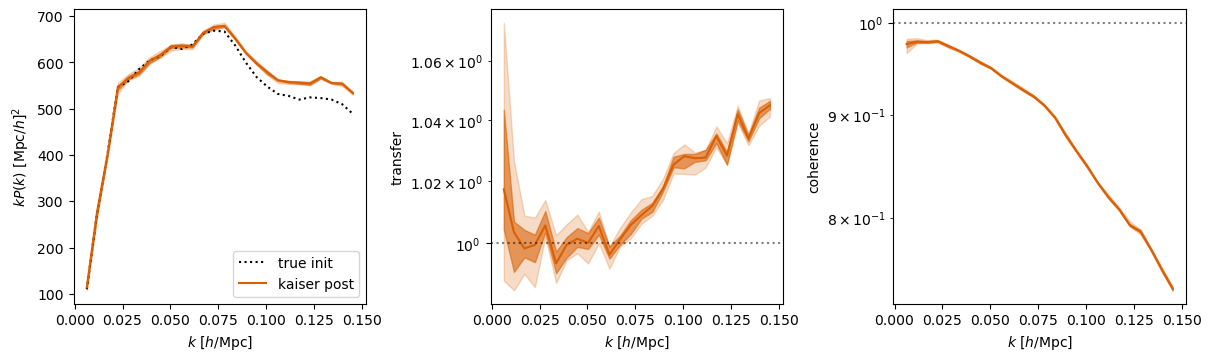

In [7]:
delta_init0 = jnp.fft.irfftn(truth0['init_mesh'])
delta_init1 = jnp.fft.irfftn(truth1['init_mesh'])
params_start_ = jit(vmap(partial(model.kaiser_post, delta_obs=delta_obs0, scale_field=1.)))(jr.split(jr.key(45), 20)) 
delta_init2 = vmap(lambda x: jnp.fft.irfftn(model.reparam(x)['init_mesh']))(params_start_)

from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
theme(usetex=False)
log = False

plt.figure(figsize=(12, 3.5), layout="constrained")
plt.subplot(131)
plot_pow(*model.spectrum(delta_init0), 'k:', log=log, label="true init")
# kptc1 = model.powtranscoh(delta_init0, delta_init1)
# plot_powtranscoh(*kptc1, log=log, label="prior")
# kptc2 = model.powtranscoh(delta_init0, delta_init2)
kptc2 = vmap(lambda x: model.powtranscoh(delta_init0, x))(delta_init2)
color = 'C1'
plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptc2), log=log, color=color, label="kaiser post")
plot_powtranscoh(*kptc2, log=log, fill=(0.68,0.95), color=color)
plt.subplot(131)
plt.legend()
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(model.selec_mesh.mean(), linestyle=':', color='k', alpha=0.5);
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_kptc.png")

In [8]:
# from montecosmo.plot import plot_mesh
# plt.figure(figsize=(12, 3.5), layout="constrained")
# ids = 0.1
# plt.subplot(131)
# plot_mesh(delta_obs0, ids=ids)
# plt.colorbar()
# plt.subplot(132)
# plot_mesh(delta_obs1, ids=ids)
# plt.colorbar()
# plt.subplot(133)
# plot_mesh(delta_obs1-delta_obs0, ids=ids)
# plt.colorbar() 

def plot_mesh2(masked, ids, axis):
    cmap = 'RdBu_r'
    quad = plot_mesh(model.masked2mesh(masked), box_size, ids, axis, cmap=cmap)
    clim = quad.get_clim()
    norm = colors.TwoSlopeNorm(0., *clim)
    quad = plot_mesh(model.masked2mesh(masked), box_size, ids, axis, cmap=cmap, vlim=None, norm=norm)

def plot_pdf(mesh, label, vlim=1e-2):
    # mesh = jnp.log10(1+mesh[mesh>1e-2])
    print(f"mean: {mesh.mean():.5e}, std: {mesh.std():.5e}, mesh p.05-.95: {np.quantile(mesh, [0.05, 0.95])}")
    if vlim is None:
        vlim = mesh.min(), mesh.max()
    elif isinstance(vlim, float):
        vlim = np.quantile(mesh, [vlim/2, 1-vlim/2])

    from scipy.stats import norm
    x = np.linspace(*vlim, 200)
    pdf = norm.pdf(x, loc=mesh.mean(), scale=mesh.std())
    color = plt.gca()._get_lines.get_next_color()
    plt.plot(x, pdf, label=label, color=color)
    plt.hist(jr.choice(jr.key(48), mesh.ravel(), (100000,), replace=False), range=vlim, bins=100, density=True, color=color, alpha=0.5)
    plt.axvline(0., color='k', linestyle=':', alpha=0.5)

    q05, q95 = np.quantile(np.asarray(mesh), [0.05, 0.95])
    plt.axvline(q05, color=color, linestyle='--', alpha=0.3)
    plt.axvline(q95, color=color, linestyle='--', alpha=0.3)
    plt.xlim(vlim)
    plt.legend();

prefix='m96_lik_softplus'
mean: 1.78034e-16, std: 1.05910e+00, mesh p.05-.95: [-1.39254815  1.97258969]
mean: -5.85469e-17, std: 1.06468e+00, mesh p.05-.95: [-1.44357688  1.96182013]


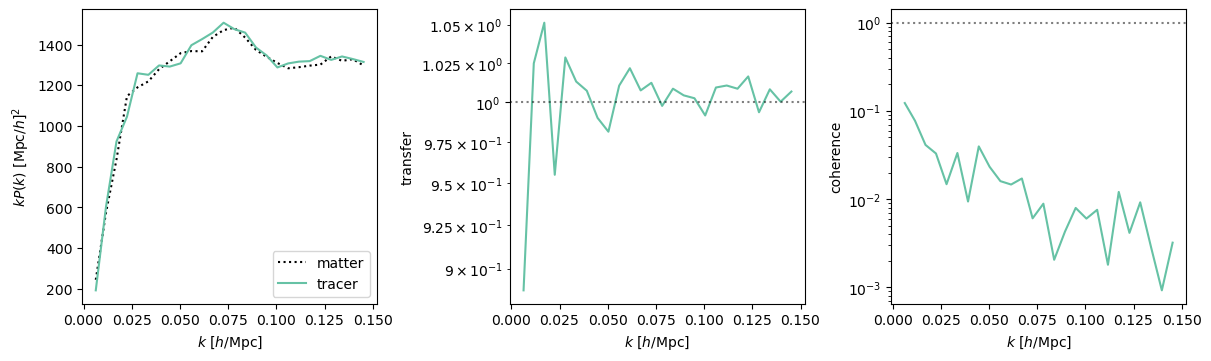

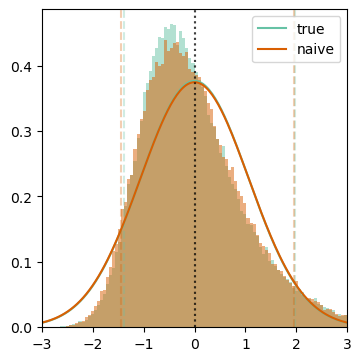

In [9]:
from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
from matplotlib import colors
theme(usetex=False)
axis = 0
ids = .1
log = False
names = ["tracer"]
prefix = f"m{model.final_shape[0]}_lik_softplus"
# prefix = f"m{model.final_shape[0]}"
cmap = None
print(f"{prefix=}")

delta_obs0 = np.array(delta_obs0)
delta_obs1 = np.array(delta_obs1)


plt.figure(figsize=(12, 3.5), layout="constrained")
plt.subplot(131)
plot_pow(*model.spectrum(delta_obs0), 'k:', log=log, label="matter")
kptc1 = model.powtranscoh(delta_obs0, delta_obs1)
plot_powtranscoh(*kptc1, log=log, label=names[0])
# kptc2 = model.powtranscoh(delta_obs0, delta_obs2)
# plot_powtranscoh(*kptc2, log=log, label=names[1])
plt.subplot(131)
plt.legend()
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(model.selec_mesh.mean(), linestyle=':', color='k', alpha=0.5);
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_kptc.png")

vlim = -3, 3.
# vlim = -2, 2.

plt.figure(figsize=(3.5, 3.5), layout="constrained")
# plot_pdf(jnp.log10(jnp.maximum(1+delta_obs0, 1e-3)), "true", vlim)
# plot_pdf(jnp.log10(jnp.maximum(1+delta_obs1, 1e-3)), "sim", vlim)
plot_pdf(delta_obs0, "true", vlim)
plot_pdf(delta_obs1, "naive", vlim)
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_pdf.png")

prefix='m96_lik_softplus'
mean: 6.29962e-17, std: 4.46504e-01, mesh p.05-.95: [-0.62827698  0.80920798]
mean: 2.63742e-17, std: 4.43584e-01, mesh p.05-.95: [-0.62286896  0.80739299]


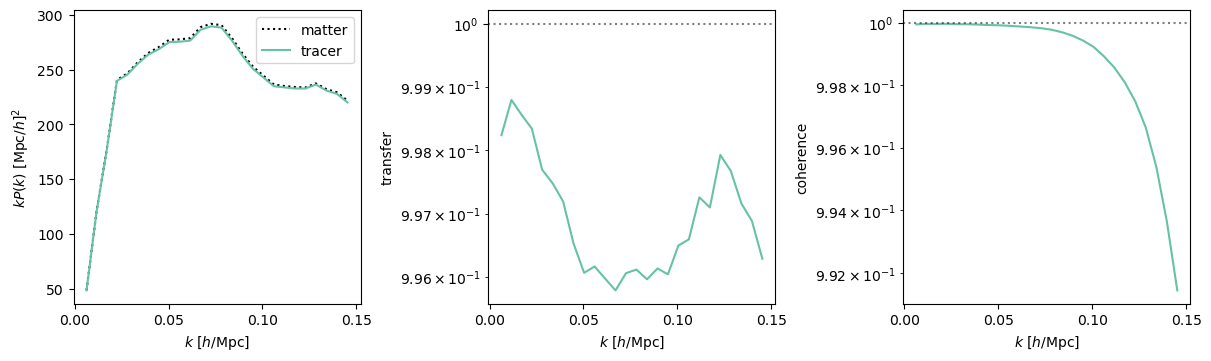

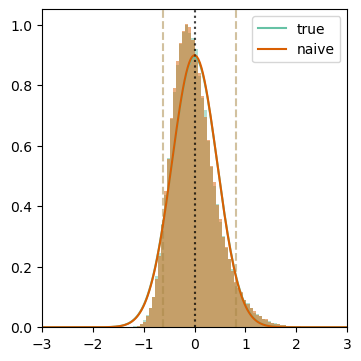

In [ ]:
from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
from matplotlib import colors
theme(usetex=False)
axis = 0
ids = .1
log = False
names = ["tracer"]
prefix = f"m{model.final_shape[0]}_lik_softplus"
# prefix = f"m{model.final_shape[0]}"
cmap = None
print(f"{prefix=}")


plt.figure(figsize=(12, 3.5), layout="constrained")
plt.subplot(131)
plot_pow(*model.spectrum(delta_obs0), 'k:', log=log, label="matter")
kptc1 = model.powtranscoh(delta_obs0, delta_obs1)
plot_powtranscoh(*kptc1, log=log, label=names[0])
# kptc2 = model.powtranscoh(delta_obs0, delta_obs2)
# plot_powtranscoh(*kptc2, log=log, label=names[1])
# delta_obs0 = jnp.load(load_dir / f'fin_paint2_interl2_deconv1_{128}.npy')-1
plt.subplot(131)
plt.legend()
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(model.selec_mesh.mean(), linestyle=':', color='k', alpha=0.5);
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_kptc.png")

vlim = -3, 3.
# vlim = -2, 2.

plt.figure(figsize=(3.5, 3.5), layout="constrained")
# plot_pdf(jnp.log10(jnp.maximum(1+delta_obs0, 1e-3)), "true", vlim)
# plot_pdf(jnp.log10(jnp.maximum(1+delta_obs1, 1e-3)), "sim", vlim)
plot_pdf(delta_obs0, "true", vlim)
plot_pdf(delta_obs1, "naive", vlim)
# plt.savefig(f"./figs/{prefix}_{"_".join(names)}_pdf.png")

### EFT

In [5]:
from montecosmo.nbody import gradient_hat, invlaplace_hat, a2g, rfftk, read, interlace
from montecosmo.bricks import Cosmology, AbacusSummit0, samp2base, regular_pos
from montecosmo.utils import chreshape, r2chshape

save_dir2 = save_dir / "lagr"
save_dir2.mkdir(parents=True, exist_ok=True)

from numpyro import sample, deterministic, render_model, handlers, distributions as dist
from numpyro.infer.util import log_density
lpt_pos = jnp.load(load_dir / f"lpt_ptcl_osamp2.0_{mesh_length}.npy")[0]
init_mesh = chreshape(jnp.fft.rfftn(jnp.load(load_dir / f'init_mesh_{mesh_length}.npy')), r2chshape(model.evol_shape))
# delta_obs0 = jnp.load(load_dir / f'tracer_6746545_paint2_deconv1_{mesh_length}.npy') - 1
# delta_mat0 = jnp.load(load_dir / f'fin_paint2_interl2_deconv1_{mesh_length}.npy') - 1
# delta_obs0 = model.count2delta(truth0['obs'])
cosmo = AbacusSummit0()

In [6]:
def lagrangian_bias2(cosmo:Cosmology, pos, a, box_size, init_mesh, 
                       b1, b2, bs2, bn2, bnp, fNL, png=None, read_order:int=2):
    delta = jnp.fft.irfftn(init_mesh)
    growths = a2g(cosmo, a)

    mesh_shape = delta.shape
    kvec = rfftk(mesh_shape)
    kmesh = sum((ki  * (m / b))**2 for ki, m, b in zip(kvec, mesh_shape, box_size))**.5 # in h/Mpc 

    # Init weights
    weights = 1.
    
    # Apply b1, punctual term
    delta_pos = read(pos, delta, read_order) * growths.squeeze()
    weights += b1 * delta_pos

    # Apply b2, punctual term
    delta2_pos = delta_pos**2
    weights += b2 * (delta2_pos - delta2_pos.mean())

    # Apply bshear2, non-punctual term
    pot = init_mesh * invlaplace_hat(kvec)
    dims = range(len(kvec))
    shear2 = 0.

    for i in dims:
        # Add diagonal terms
        nabi = gradient_hat(kvec, i)
        shear2 += jnp.fft.irfftn(nabi**2 * pot - init_mesh / 3)**2
        for j in dims[i+1:]:
            # Add strict-up-triangle terms (counted twice)
            nabj = gradient_hat(kvec, j)
            shear2 += 2 * jnp.fft.irfftn(nabi * nabj * pot)**2

    shear2_pos = read(pos, shear2, read_order) * growths.squeeze()**2
    weights += bs2 * (shear2_pos - shear2_pos.mean())

    # Apply bnabla2, higher-order term
    delta_nab2 = jnp.fft.irfftn( - kmesh**2 * init_mesh)

    delta_nab2_pos = read(pos, delta_nab2, read_order) * growths.squeeze()
    weights += bn2 * delta_nab2_pos

    # # Compute separately bnablapar, velocity bias term
    # delta_nabpar_pos = jnp.stack([
    #             read(pos, jnp.fft.irfftn(gradient_hat(kvec, i) * (m / b) * init_mesh), read_order) 
    #             for i, (m, b) in enumerate(zip(mesh_shape, box_size))], axis=-1) # in h/Mpc 
    # dvel = bnp * delta_nabpar_pos * growths
    dvel = 0.

    return weights, dvel

def euler_bias2(cosmo:Cosmology, a, box_size, evol_mesh, 
                       b1, b2, bs2, bn2, bnp, fNL, png=None, read_order:int=2):
    delta = jnp.fft.irfftn(evol_mesh)

    mesh_shape = delta.shape
    kvec = rfftk(mesh_shape)
    kmesh = sum((ki  * (m / b))**2 for ki, m, b in zip(kvec, mesh_shape, box_size))**.5 # in h/Mpc 

    # Init weights
    weights = 1.
    
    # Apply b1, punctual term
    weights += b1 * delta

    # Apply b2, punctual term
    weights += b2 * (delta**2 - (delta**2).mean())

    # Apply bshear2, non-punctual term
    pot = evol_mesh * invlaplace_hat(kvec)
    dims = range(len(kvec))
    shear2 = 0.

    for i in dims:
        # Add diagonal terms
        nabi = gradient_hat(kvec, i)
        shear2 += jnp.fft.irfftn(nabi**2 * pot - evol_mesh / 3)**2
        for j in dims[i+1:]:
            # Add strict-up-triangle terms (counted twice)
            nabj = gradient_hat(kvec, j)
            shear2 += 2 * jnp.fft.irfftn(nabi * nabj * pot)**2

    weights += bs2 * (shear2 - shear2.mean())

    # Apply bnabla2, higher-order term
    delta_nab2 = jnp.fft.irfftn( - kmesh**2 * evol_mesh)
    weights += bn2 * delta_nab2

    # # Compute separately bnablapar, velocity bias term
    # delta_nabpar = jnp.stack([
    #             jnp.fft.irfftn(gradient_hat(kvec, i) * (m / b) * evol_mesh) 
    #             for i, (m, b) in enumerate(zip(mesh_shape, box_size))], axis=-1) # in h/Mpc 
    # dvel = bnp * delta_nabpar
    dvel = 0.

    return weights, dvel


def prior(temp=1.):
    # Sample, reparametrize, and register cosmology and biases
    tup = ()
    for g in ['bias','syst']:
        dic = model._sample(model.groups[g]) # sample               
        dic = samp2base(dic, model.latents, inv=False, temp=temp) # reparametrize
        tup += ({k: deterministic(k, v) for k, v in dic.items()},) # register base params
    return tup


def lagr_model():
    bias, syst = prior()
    cosmo._workspace = {} # HACK: force recompute by jaxpm cosmo to get g2, f2 => TODO: add g2, f2 to jaxcosmo
    pos = regular_pos(model.evol_shape, model.ptcl_shape)
    lbe_weights, dvel = lagrangian_bias2(cosmo, pos, model.a_obs, model.box_size, init_mesh=init_mesh, **bias, read_order=1)

    # ebe_weights, dvel = euler_bias2(cosmo, model.a_obs, model.box_size, delta_mat0, **bias, read_order=1)

    pos = lpt_pos * model.paint_shape / model.ptcl_shape
    mesh = interlace(pos, model.paint_shape, lbe_weights, model.paint_order, model.interlace_order, 
                        kernel_type=model.kernel_type, oversamp=model.paint_oversamp, deconv=model.paint_deconv)
    mesh *= (model.paint_shape / model.ptcl_shape).prod()
    mesh = chreshape(mesh, r2chshape(model.final_shape))
    mesh = jnp.fft.irfftn(mesh)

    obs = model.likelihood((mesh, syst))
    return obs

    # mesh -= 1
    # # print("mesh", mesh.mean(), mesh.std(), mesh.min(), mesh.max())
    
    # rcounts = syst['ngbars'] * model.cell_length**3
    # mean_count = rcounts.mean()

    # # obs = sample('obs', dist.Normal((1 + mesh) * mean_count, mean_count**.5))
    # # obs = sample('obs', dist.Normal(mesh, mean_count**-.5))

    # # posit_fn = lambda x: jnp.maximum(x, 1e-9)
    # # posit_fn = jnp.abs
    # posit_fn = lambda x: jnp.log(1 + jnp.exp(x))
    # obs = sample('obs', dist.Normal(mesh, (posit_fn(1 + syst['sigma_delta'] * mesh) / mean_count)**.5))

    # # obs = sample('obs', dist.Poisson(jnp.maximum(1 + mesh, 1e-9) * mean_count)) # / mean_count - 1
    # # obs = sample('obs', dist.Poisson(jnp.abs(1 + mesh) * mean_count)) # / mean_count - 1
    # return obs

### Fit EFT

In [16]:
params_names = ['b1','b2','bs2','bn2','ngbars', 'sigma_0', 'sigma_delta']
# params_names = ['b1','b2','bs2','bn2','ngbars']
# params_names = ['b1','b2','bs2','bn2']
params_start_ = {k: v for k, v in model.loc_fid.items() if k in params_names}
params_start_['b1'] = 1.15
# params_start_['b1'] = 1.
print(params_start_)
params_start_ = model.reparam(params_start_, inv=True)
print('start params:', params_start_.keys())

data = model.reparam({
                    'obs': truth0['obs'], ############
                    # 'obs': (truth0['obs']+1)*model.count_fid, 
                    # 'ngbars': truth0['ngbars'],
                    #   'ngbars': 1000,
                    'bnp':0., 'fNL':0.,}, inv=True)
cond_lagr_model = handlers.condition(lagr_model, data=data)
def potential(params={}):
    return - log_density(cond_lagr_model, (), {}, params)[0]

# render_model(cond_eft_model)
# potential_valgrad = (value_and_grad(potential))
potential_valgrad = jit(value_and_grad(potential))
potential_valgrad(params_start_)[0]

{'b1': 1.15, 'b2': 0.0, 'bs2': 0.0, 'bn2': 0.0, 'ngbars': array([0.00084332]), 'sigma_0': 0.000843318125, 'sigma_delta': 1.0}
start params: dict_keys(['b1_', 'b2_', 'bs2_', 'bn2_', 'ngbars_', 'sigma_0_', 'sigma_delta_'])


Array(4054140.02830739, dtype=float64)

mean: -1.07173e-16, std: 1.28065e+00, mesh p.05-.95: [-1.65906254  2.37905324]
mean: -3.05203e-17, std: 1.38386e+00, mesh p.05-.95: [-1.73609704  2.56755919]
mean: -1.17799e-16, std: 1.39607e+00, mesh p.05-.95: [-1.72158042  2.64063147]


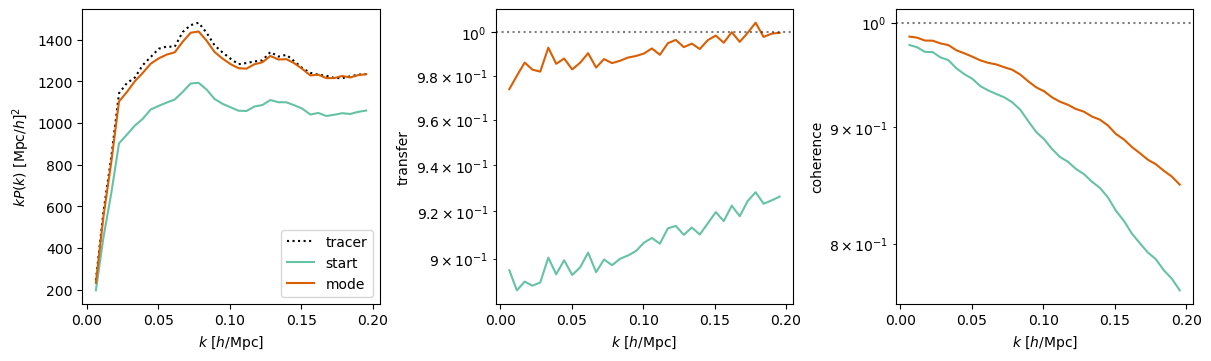

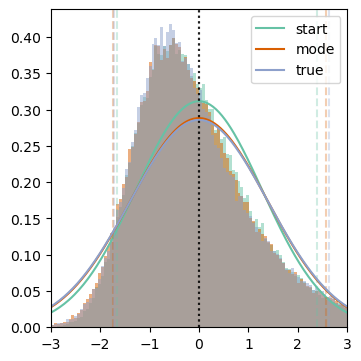

In [ ]:
prefix = f"m{mesh_length}_lagr_densdep3_{"_".join(params_names)}"
params_ = dict(jnp.load(save_dir2 / f'params_mode_{prefix}.npz'))
# params_ = params_start_
params = model.reparam(params_)

pred_lagr_model = handlers.condition(lagr_model, data={k:v for k,v in data.items() if k != "obs"} | params_start_)
delta_obs1 = model.count2delta((handlers.seed(pred_lagr_model, 42))())
# delta_obs1 = delta_obs1 / model.count_fid - 1
pred_lagr_model = handlers.condition(lagr_model, data={k:v for k,v in data.items() if k != "obs"} | params_)
delta_obs2 = model.count2delta((handlers.seed(pred_lagr_model, 42))())
# delta_obs2 = delta_obs2 / model.count_fid - 1
# display(render_model(pred_eft_model))

from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
theme(usetex=False)
log = False

plt.figure(figsize=(12, 3.5), layout="constrained")
plt.subplot(131)
plot_pow(*model.spectrum(delta_obs0), 'k:', log=log, label="tracer")
kptc1 = model.powtranscoh(delta_obs0, delta_obs1)
plot_powtranscoh(*kptc1, log=log, label="start")
kptc2 = model.powtranscoh(delta_obs0, delta_obs2)
plot_powtranscoh(*kptc2, log=log, label="mode")
plt.subplot(131)
plt.legend()
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(model.selec_mesh.mean(), linestyle=':', color='k', alpha=0.5);
# plt.savefig(save_dir2 / f"{prefix}_kptc.png")
plt.savefig(f"./figs/{prefix}_kptc.png")

vlim = -3, 3.
# vlim = -2, 2.

plt.figure(figsize=(3.5, 3.5), layout="constrained")
plot_pdf(delta_obs1, "start", vlim)
plot_pdf(delta_obs2, "mode", vlim)
plot_pdf(delta_obs0, "true", vlim)
# plt.yscale('log')
# plt.savefig(save_dir2 / f"{prefix}_pdf.png")
plt.savefig(f"./figs/{prefix}_pdf.png")

In [17]:
prefix = f"m{mesh_length}_lagr_densdep3_{"_".join(params_names)}"


In [18]:
from jax.example_libraries.optimizers import adam
from tqdm import tqdm
n_epochs = 100
energies = []

lr0 = 1.
# lr_fn = lambda i: lr0 / (1 + i)**.5
lr_fn = 1e-1
opt_init, opt_update, get_params = adam(lr_fn)
opt_state = opt_init(params_start_)
# opt_state = opt_init(params_)

def step(step, opt_state):
    value, pot_grad = potential_valgrad(get_params(opt_state))
    opt_state = opt_update(step, pot_grad, opt_state)
    return value, opt_state

for i_epoch in tqdm(range(n_epochs)):
    value, opt_state = step(i_epoch, opt_state)
    energies.append(float(value))
params_ = get_params(opt_state)
jnp.savez(save_dir2 / f'params_mode_{prefix}.npz', **params_)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.05it/s]


Last potential: 3900812.428394662
Final params:
 {'b1_': Array(6.00576091, dtype=float64), 'b2_': Array(2.93792863, dtype=float64), 'bn2_': Array(0.955546, dtype=float64), 'bs2_': Array(-2.36511329, dtype=float64), 'ngbars_': Array([0.13471851], dtype=float64), 'sigma_0_': Array(-3.39615606, dtype=float64), 'sigma_delta_': Array(-3.95297875, dtype=float64)} 
 {'b1': Array(1.20028805, dtype=float64), 'b2': Array(0.29379286, dtype=float64), 'bs2': Array(-0.23651133, dtype=float64), 'bn2': Array(0.955546, dtype=float64), 'ngbars': Array([0.00084345], dtype=float64), 'sigma_0': Array(0.0005037, dtype=float64), 'sigma_delta': Array(0.60470213, dtype=float64)}


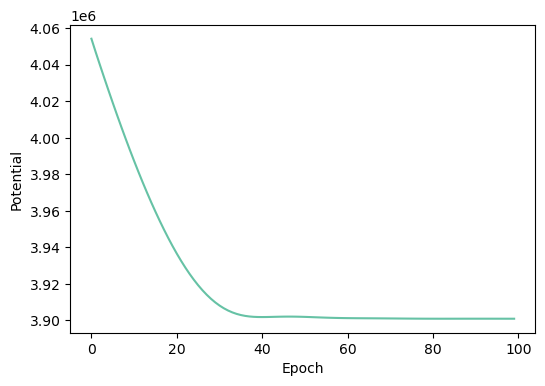

In [19]:
plt.figure(figsize=(6,4))
plt.plot(energies)
print("Last potential:", energies[-1])
plt.xlabel("Epoch"), plt.ylabel("Potential")
params = model.reparam(params_)
print("Final params:\n", params_, '\n', params)
plt.show()

Last potential: 3903092.2041213023
Final params:
 {'b1_': Array(4.44587007, dtype=float64), 'b2_': Array(3.06682545, dtype=float64), 'bn2_': Array(-1.25521582, dtype=float64), 'bs2_': Array(-2.26231791, dtype=float64), 'ngbars_': Array([3.86735434], dtype=float64), 'sigma_0_': Array(-3.38733661, dtype=float64), 'sigma_delta_': Array(-4.00409623, dtype=float64)} 
 {'b1': Array(1.1222935, dtype=float64), 'b2': Array(0.30668254, dtype=float64), 'bs2': Array(-0.22623179, dtype=float64), 'bn2': Array(-1.25521582, dtype=float64), 'ngbars': Array([0.00084719], dtype=float64), 'sigma_0': Array(0.00050458, dtype=float64), 'sigma_delta': Array(0.59959038, dtype=float64)}


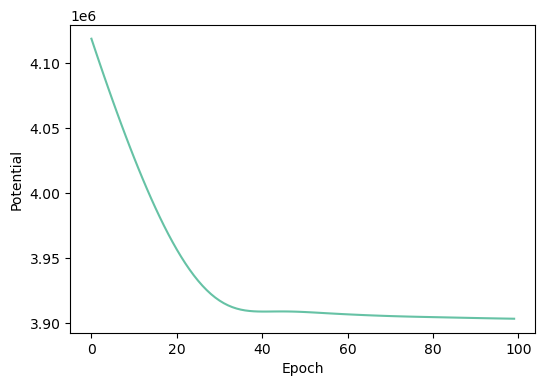

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(energies)
print("Last potential:", energies[-1])
plt.xlabel("Epoch"), plt.ylabel("Potential")
params = model.reparam(params_)
print("Final params:\n", params_, '\n', params)
plt.show()

Last potential: 3900980.677159021
Final params:
 {'b1_': Array(1.53575572, dtype=float64), 'b2_': Array(2.97164289, dtype=float64), 'bn2_': Array(0.36372419, dtype=float64), 'bs2_': Array(-2.32173775, dtype=float64), 'ngbars_': Array([2.48261483], dtype=float64), 'sigma_0_': Array(-3.39987779, dtype=float64), 'sigma_delta_': Array(-3.9856637, dtype=float64)} 
 {'b1': Array(1.17678779, dtype=float64), 'b2': Array(0.29716429, dtype=float64), 'bs2': Array(-0.23217377, dtype=float64), 'bn2': Array(0.36372419, dtype=float64), 'ngbars': Array([0.0008458], dtype=float64), 'sigma_0': Array(0.00050333, dtype=float64), 'sigma_delta': Array(0.60143363, dtype=float64)}


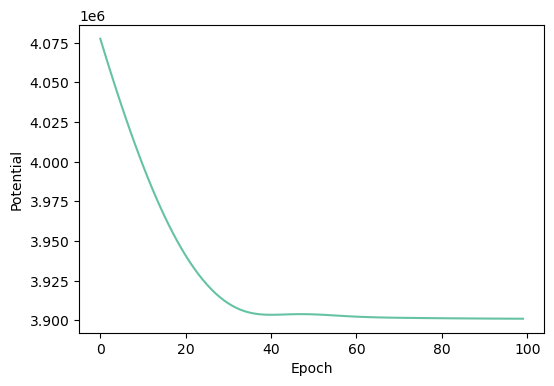

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(energies)
print("Last potential:", energies[-1])
plt.xlabel("Epoch"), plt.ylabel("Potential")
params = model.reparam(params_)
print("Final params:\n", params_, '\n', params)
plt.show()

Last potential: 2056226.3277011965
Final params:
 {'b1_': Array(18.16647095, dtype=float64), 'b2_': Array(2.8243579, dtype=float64), 'bn2_': Array(0.94515626, dtype=float64), 'bs2_': Array(-2.06619385, dtype=float64), 'ngbars_': Array([-0.14546657], dtype=float64), 'sigma_0_': Array(-3.1418324, dtype=float64), 'sigma_delta_': Array(-3.86265629, dtype=float64)} 
 {'b1': Array(1.18166471, dtype=float64), 'b2': Array(0.28243579, dtype=float64), 'bs2': Array(-0.20661939, dtype=float64), 'bn2': Array(0.94515626, dtype=float64), 'ngbars': Array([0.00084317], dtype=float64), 'sigma_0': Array(0.00052913, dtype=float64), 'sigma_delta': Array(0.61373437, dtype=float64)}


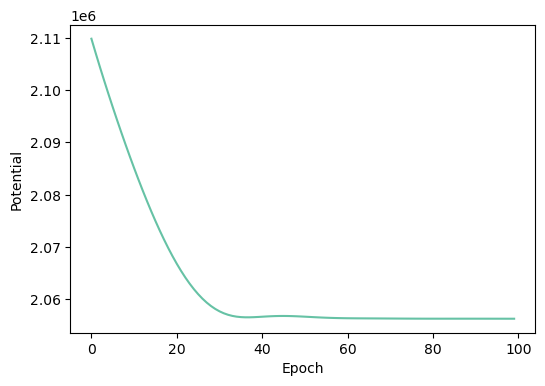

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(energies)
print("Last potential:", energies[-1])
plt.xlabel("Epoch"), plt.ylabel("Potential")
params = model.reparam(params_)
print("Final params:\n", params_, '\n', params)
plt.show()

Last potential: 2059048.750518009
Final params:
 {'b1_': Array(6.88106271, dtype=float64), 'b2_': Array(2.98258102, dtype=float64), 'bn2_': Array(-3.99403294, dtype=float64), 'bs2_': Array(-2.01935874, dtype=float64), 'ngbars_': Array([5.50678976], dtype=float64), 'sigma_0_': Array(-3.11102152, dtype=float64), 'sigma_delta_': Array(-3.89849566, dtype=float64)} 
 {'b1': Array(1.06881063, dtype=float64), 'b2': Array(0.2982581, dtype=float64), 'bs2': Array(-0.20193587, dtype=float64), 'bn2': Array(-3.99403294, dtype=float64), 'ngbars': Array([0.00084882], dtype=float64), 'sigma_0': Array(0.00053222, dtype=float64), 'sigma_delta': Array(0.61015043, dtype=float64)}


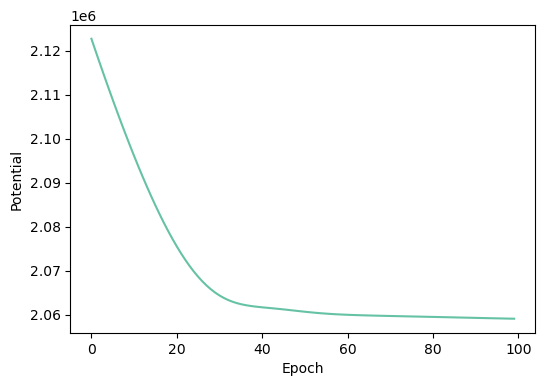

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(energies)
print("Last potential:", energies[-1])
plt.xlabel("Epoch"), plt.ylabel("Potential")
params = model.reparam(params_)
print("Final params:\n", params_, '\n', params)
plt.show()

Last potential: 297321.44848034007
Final params:
 {'b1_': Array(16.01737699, dtype=float64), 'b2_': Array(2.90364448, dtype=float64), 'bn2_': Array(0.07532313, dtype=float64), 'bs2_': Array(-1.92330142, dtype=float64), 'ngbars_': Array([10.12522269], dtype=float64), 'sigma_delta_': Array(-1.72785117, dtype=float64)} 
 {'b1': Array(1.16017377, dtype=float64), 'b2': Array(0.29036445, dtype=float64), 'bs2': Array(-0.19233014, dtype=float64), 'bn2': Array(0.07532313, dtype=float64), 'ngbars': Array([0.00085013], dtype=float64), 'sigma_delta': Array(0.82721488, dtype=float64)}


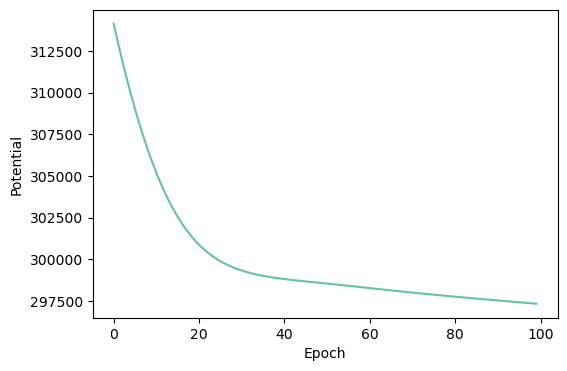

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(energies)
print("Last potential:", energies[-1])
plt.xlabel("Epoch"), plt.ylabel("Potential")
params = model.reparam(params_)
print("Final params:\n", params_, '\n', params)
plt.show()

Last potential: 298406.25099462876
Final params:
 {'b1_': array(18.33722723), 'b2_': array(2.91309443), 'bn2_': array(1.46935295), 'bs2_': array(-1.80563572), 'ngbars_': array([10.04342102])} 
 {'b1': Array(1.18337227, dtype=float64), 'b2': Array(0.29130944, dtype=float64), 'bs2': Array(-0.18056357, dtype=float64), 'bn2': Array(1.46935295, dtype=float64), 'ngbars': Array([0.00085004], dtype=float64)}


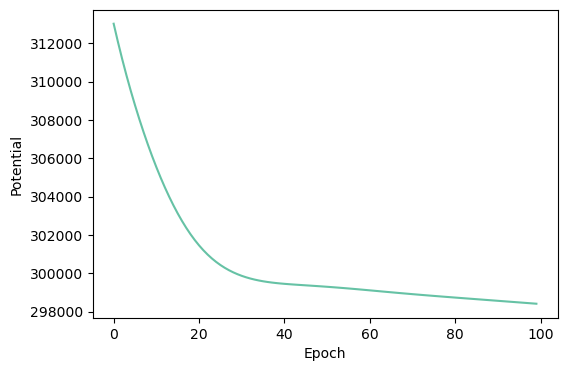

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(energies)
print("Last potential:", energies[-1])
plt.xlabel("Epoch"), plt.ylabel("Potential")
print("Final params:\n", params_, '\n', model.reparam(params_))
plt.show()

In [ ]:
print("Final params:\n", params_, '\n', model.reparam(params_))

Final params:
 {'b1_': array(18.36147027), 'b2_': array(2.91450078), 'bn2_': array(1.46964203), 'bs2_': array(-1.80547173)} 
 {'b1': Array(1.1836147, dtype=float64), 'b2': Array(0.29145008, dtype=float64), 'bs2': Array(-0.18054717, dtype=float64), 'bn2': Array(1.46964203, dtype=float64)}


### Inspect noise

mean: -1.29562e-17, std: 9.74007e-01, mesh p.05-.95: [-1.31781359  1.54788391]


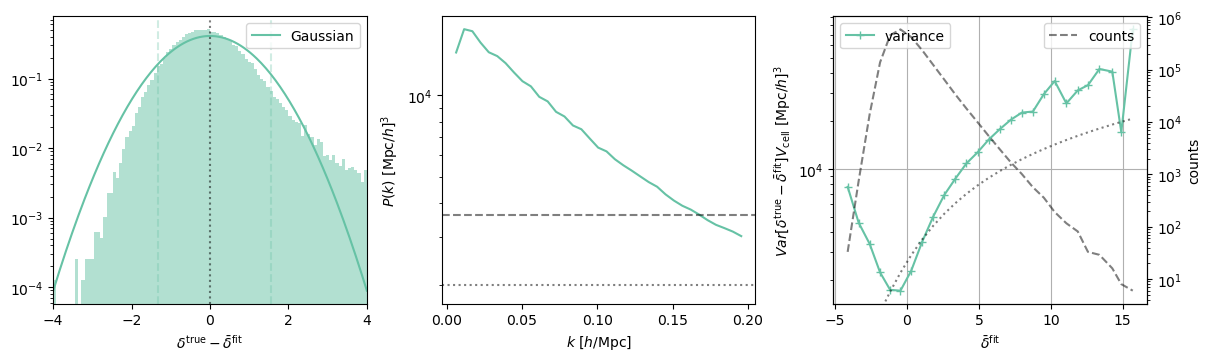

In [ ]:
pred_lagr_model = handlers.condition(lagr_model, data={k:v for k,v in data.items() if k != "obs"} | {'ngbars_':1e9, 'sigma_0_':1e9} | params_)
delta_obs1 = model.count2delta((handlers.seed(pred_lagr_model, 42))())
######### ngbars_ sigma0
pred_lagr_model = handlers.condition(lagr_model, data={k:v for k,v in data.items() if k != "obs"} | params_)
delta_obs0 = model.count2delta((handlers.seed(pred_lagr_model, 42))())
# delta_obs0 = model.count2delta(truth0['obs'])
noises = delta_obs0 - delta_obs1

# # from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh, theme
# # from matplotlib import colors
# theme(usetex=False, font_size=12)
# log = False

# plt.figure(figsize=(12, 3.5), layout="constrained")
# plt.subplot(131)
# plot_pow(*model.spectrum(delta_obs0), 'k:', log=log, label="tracer")
# kptc1 = model.powtranscoh(delta_obs0, delta_obs1)
# plot_powtranscoh(*kptc1, log=log, label="mode, no noise")
# plt.subplot(131)
# plt.legend()
# plt.subplot(132)
# plt.axhline(1., linestyle=':', color='k', alpha=0.5)
# plt.subplot(133)
# plt.axhline(model.selec_mesh.mean(), linestyle=':', color='k', alpha=0.5);

# plt.savefig(save_dir2 / f"{prefix}_nonkptc.png")




plt.figure(figsize=(12, 3.5), layout="constrained")
plt.subplot(131)
# print("noise mean:", noises.mean(), "std:", noises.std())
# plt.hist(jr.choice(jr.key(48), noises.ravel(), (50000,)), bins=100, density=True)
# x = np.linspace(noises.min(), noises.max(), 200)
# from scipy.stats import norm
# pdf = norm.pdf(x, loc=noises.mean(), scale=noises.std())
# plt.plot(x, pdf, label="Gaussian")

vlim = -4., 4.
plot_pdf(noises, "Gaussian", vlim)
plt.xlabel('$\\delta^\\mathrm{true} - \\bar\\delta^\\mathrm{fit}$')
plt.yscale('log')
plt.legend()


plt.subplot(132)
plot_pow(*model.spectrum(noises), log=True, label="noise")
plt.xscale('linear')
plt.axhline(1 / params['sigma_0'], color='k', linestyle=':', alpha=0.5)
plt.axhline(noises.var() * model.cell_length**3, color='k', linestyle='--', alpha=0.5)
plt.ylim(bottom=1.7e3)

plt.subplot(133)
def var_value(tmesh, vmesh, vedges:int|float|list, min_count=5):
    tmesh, vmesh = tmesh.reshape(-1), vmesh.reshape(-1)
    if isinstance(vedges, int):
        n_vedges = vedges
        vmin, vmax = vmesh.min(), vmesh.max()
        dv = (vmax - vmin) / n_vedges
        vedges = np.linspace(vmin, vmax, n_vedges, endpoint=False)
        vedges += dv / 2

    dig = np.digitize(vmesh, vedges)
    vcount = np.bincount(dig)[1:-1]
    vmask = vcount >= min_count
    vcount = vcount[vmask]

    vmean = np.bincount(dig, weights=vmesh)[1:-1]
    vmean = vmean[vmask]
    vmean = vmean / vcount

    tmean = np.bincount(dig, weights=tmesh)[1:-1]
    tmean = tmean[vmask]
    tmean = tmean / vcount

    tvar = np.bincount(dig, weights=tmesh**2)[1:-1]
    tvar = tvar[vmask]
    tvar = tvar / vcount
    tvar = tvar - tmean**2

    return vcount, vmean, tmean, tvar

vcount, vmean, tmean, tvar = var_value(noises * model.cell_length**(3/2), delta_obs1, 35, 5)

plt.subplot(133)
ax = plt.gca()
# ax.plot(vmean, tmean, '-+', label='mean')
ax.plot(vmean, tvar, '-+', label='variance')
ax.set_xlabel('$\\bar\\delta^\\mathrm{fit}$')
ax.set_ylabel('$Var[\\delta^\\mathrm{true} - \\bar\\delta^\\mathrm{fit}] V_\\mathrm{cell}$ [Mpc/$h$]$^3$')
ax.set_yscale('log')
ax.grid(True)

ax2 = ax.twinx()
ax2.plot(vmean, vcount, 'k--', alpha=0.5, label='counts')
ax2.set_ylabel('counts')
ax2.set_yscale('log')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.sca(ax)
plt.ylim(plt.ylim())
# posit_fn = lambda x: jnp.maximum(x, 1e-9)
# posit_fn = jnp.abs
posit_fn = lambda x: jnp.log(1 + jnp.exp(x))
# plt.axhline(1 / truth0['sigma_0'], color='k', linestyle=':', alpha=0.5)
plt.plot(vmean, posit_fn(1 + params['sigma_delta'] * vmean) / params['sigma_0'], color='k', linestyle=':', alpha=0.5)

plt.savefig(save_dir2 / f"{prefix}_noise.png")

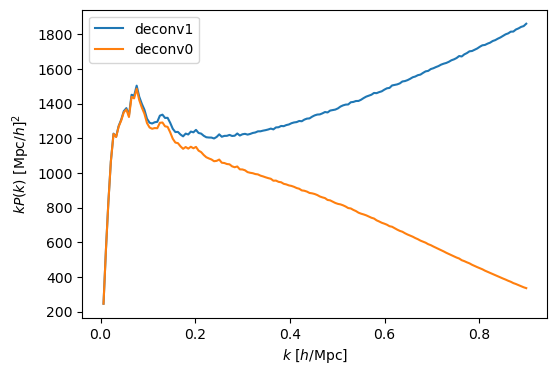

(Array(3.91776232e-17, dtype=float64),)

In [18]:
# delta_obs0 = jnp.load(load_dir / f'tracer_6746545_paint2_deconv1_{576}.npy') - 1

from montecosmo.plot import plot_mesh, plot_pow, theme
from montecosmo.metrics import spectrum
from montecosmo.nbody import rectangular_hat, deconv_paint, rfftk


kvec = rfftk(delta_obs0.shape)
delta_obs1 = jnp.fft.rfftn(delta_obs0)
delta_obs1 *= rectangular_hat(kvec, order=2)
delta_obs1 = jnp.fft.irfftn(delta_obs1)


box_size = np.array(3*(2000,))  # Mpc/h
kpow0 = spectrum(delta_obs0, box_size=box_size)
kpow1 = spectrum(delta_obs1, box_size=box_size)

plt.figure(figsize=(6,4))
plot_pow(*kpow0, label='deconv1')
plot_pow(*kpow1, label='deconv0')
plt.legend()
plt.show()
delta_obs0.mean(), 

In [ ]:
model.reset()
params_ = dict(jnp.load(save_dir / f'params_mode_{model.mesh_shape[0]}.npz'))
print("Final params:\n", params_, '\n', model.reparam(params_))
truth1 = model.predict(samples=truth | params_ | {'ngbars':1000}, hide_base=False, hide_samp=False, from_base=True)
delta_obs1 = truth1['obs']

Final params:
 {'b1_': array(11.76061254), 'b2_': array(2.53433619), 'bn2_': array(0.69443178), 'bs2_': array(-3.26317035)} 
 {'b1': Array(1.11760613, dtype=float64), 'b2': Array(0.25343362, dtype=float64), 'bs2': Array(-0.32631704, dtype=float64), 'bn2': Array(0.69443178, dtype=float64)}


## Lapprox

In [ ]:
from jax.example_libraries.optimizers import adam
from tqdm import tqdm
lr0 = 1.
n_epochs = 500
energies = []

lr_fn = lambda i: lr0 / (1 + i)**.5
opt_init, opt_update, get_params = adam(lr_fn)
opt_state = opt_init(params_start_)
# opt_state = opt_init(params)

def step(step, opt_state):
    value, pot_grad = potential_valgrad(get_params(opt_state))
    opt_state = opt_update(step, pot_grad, opt_state)
    return value, opt_state

for i_epoch in tqdm(range(n_epochs)):
    value, opt_state = step(i_epoch, opt_state)
    energies.append(float(value))
params_ = get_params(opt_state)
jnp.savez(save_dir / f'params_mode_{model.mesh_shape[0]}.npz', **params_)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:08<00:00,  7.29it/s]


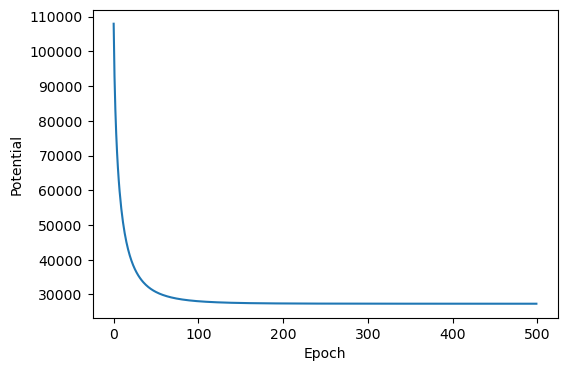

In [5]:
plt.figure(figsize=(6,4))
plt.plot(energies)
plt.xlabel("Epoch"), plt.ylabel("Potential")
plt.show()

Chains(data={'b2': Array(0.18354903, dtype=float64), 'b1': Array(1.2183641, dtype=float64), 'bn2': Array(-22.77584076, dtype=float64), 'bs2': Array(0.01984765, dtype=float64)}, groups={}, labels={})


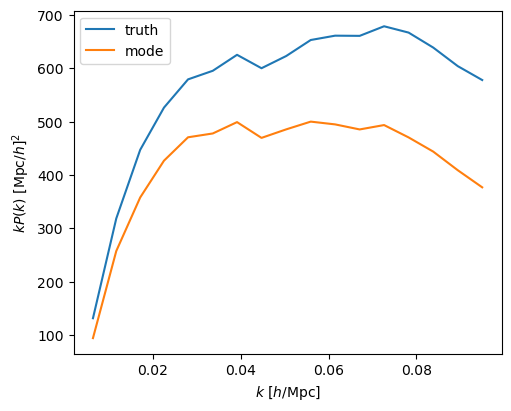

In [ ]:
from montecosmo.chains import Chains
params_ = dict(jnp.load(save_dir / f'params_mode_{model.mesh_shape[0]}.npz'))
post_mode = Chains(model.reparam(params_))
theta_mode, init_mode = post_mode[['*~init_mesh'],'init_mesh']
print(theta_mode)
plt.figure(figsize=(5, 4), layout="constrained")
plot_pow(*model.spectrum(truth['init_mesh']), label='truth')
plot_pow(*model.spectrum(init_mode), label='mode')
plt.legend();

In [ ]:
from montecosmo.chains import Chains
from montecosmo.lapprox import cov_x_from_pot_x_y

theta, tmesh = Chains(params_)[['*~init_mesh_'],['init_mesh_']]
(theta, unravel), (tmesh, _) = theta.ravel(0), tmesh.ravel(0)
names = list(unravel(theta).keys())
labels = [model.labels[k] for k in names]

def pot_fn(theta, mesh):
    params = unravel(theta) | {"init_mesh_": mesh}
    return model.potential(params.data)

cov_x, schur = cov_x_from_pot_x_y(pot_fn, theta, tmesh, method='hutchinson', chunk_size=128)
jnp.save(save_dir / f'cov_mode_{model.mesh_shape[0]}.npy', cov_x)
jnp.save(save_dir / f'schur_mode_{model.mesh_shape[0]}.npy', schur)
print(jnp.linalg.eigvalsh(cov_x))

[-1.11442354e-03  7.03347360e-03  1.42559890e-02  7.91406757e+00]


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/getdist/gaussian_mixtures.py:39: RuntimeWarning: invalid value encountered in sqrt
  self.norms = (2 * np.pi) ** (0.5 * self.dim) * np.array([np.sqrt(np.linalg.det(cov)) for cov in self.covs])


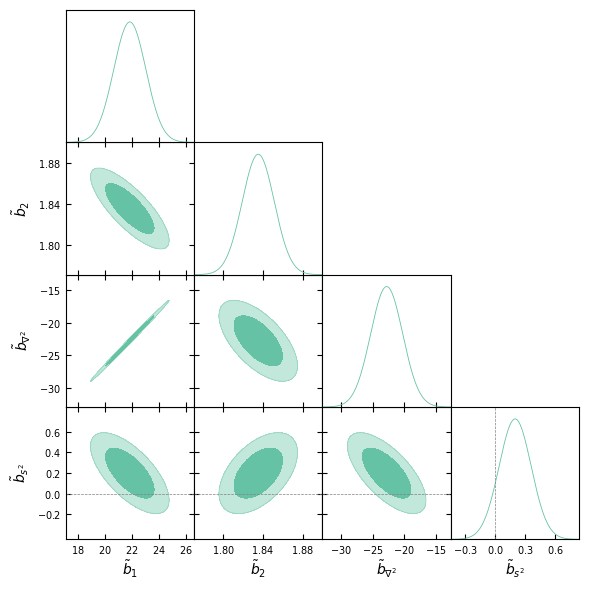

In [77]:
%matplotlib inline
from getdist import plots, gaussian_mixtures
from montecosmo.plot import SetDark2

gd_fisher = gaussian_mixtures.GaussianND(theta, cov_x, names=names, labels=labels, label='Full Lapprox')
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(gd_fisher, 
                filled=True, 
                contour_colors=[SetDark2(0)], 
                markers=truth)

In [ ]:
n_chains = 2
model.reset()
truth2 = model.predict(samples=(2,30), hide_base=True, hide_samp=True, from_base=True)

In [58]:
batch_ndim = 2
theta = Chains(truth2, model.groups_)[['*~init_mesh_','~init_mesh','~obs']]
out, unravel = theta.ravel(1)
print(theta.shape)
print(out.shape)
print(unravel(out).shape)

{'Omega_m_': (2, 30), 'alpha_ap_': (2, 30), 'alpha_iso_': (2, 30), 'b1_': (2, 30), 'b2_': (2, 30), 'bn2_': (2, 30), 'bnp_': (2, 30), 'bs2_': (2, 30), 'fNL_': (2, 30), 'ngbars_': (2, 30, 1), 'sigma8_': (2, 30)}
(2, 330)
{'Omega_m_': (2, 30), 'alpha_ap_': (2, 30), 'alpha_iso_': (2, 30), 'b1_': (2, 30), 'b2_': (2, 30), 'bn2_': (2, 30), 'bnp_': (2, 30), 'bs2_': (2, 30), 'fNL_': (2, 30), 'ngbars_': (2, 30, 1), 'sigma8_': (2, 30)}


Removed no burn in


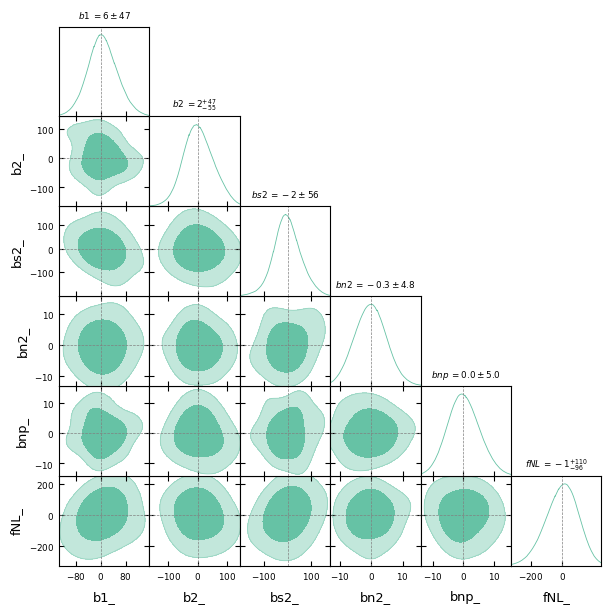

In [66]:
from getdist import plots
from montecosmo.plot import SetDark2
gdsamp = theta[['bias_']].to_getdist()
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)